###### 실험 과정 요약

실험 배경 : 오직 RNN만을 사용하여 기업명을 통해 카테고리를 분류하는 모델 구현 및 성능 개선

실험 대상 : Baseline RNN 모델의 성능 개선을 위한 방법론 적용(데이터 전처리 / 모델 구조 / 하이퍼파라미터 등 수정)

실험 설정 : early stopping + epochs 50 + Adam(learning_rate=0.001) + seed 42 + batch_size=64 고정

1. 기초 전처리 및 SimpleRNN으로 성능 확인
- Baseline -> Test Loss: 1.2631 Test Accuracy: 0.5615

2. 데이터 전처리 보완 (음절 단위 변환, class_weight)
- 음절 단위 변환 -> Test Loss: 1.1575 Test Accuracy: 0.5877
- 주식회사, (주) 등 정규화 -> Test Loss: 1.1307 Test Accuracy: 0.5985
- class_weigth 적용 -> Test Accuracy: 0.1374
    - 소수 클래스에 부여된 큰 가중치 때문에, 해당 클래스에서 오분류가 발생하면 손실 값이 매우 커지고, 이는 모델 파라미터를 업데이트하는 그래디언트를 매우 불안정하게 만듬.
    - SimpleRNN과 같이 상대적으로 단순한 모델이 이러한 극단적인 가중치를 감당하면서 안정적으로 학습하기는 어려움이 있는 것으로 파악.
    - 그러나, 기존에는 제조업으로만 분류하여 높은 정확도가 나오는 모델에 비해 소수 클래스로 분류하기 시작한 것이 긍정적인 신호.
- focal loss -> Test Loss: 0.1706 Test Accuracy: 0.6003 (파라미터 변경 및 focal loss는 학습률을 낮춰야 효과과 있으므로 추후 테스트 예정)
    - focal loss의 alpha를 사용해 class_weight를 부여할 경우 정확도는 0.2정도로 떨어지나, 소수 클래스 분류 정확도가 향상된 것이 긍정적인 신호.
- 데이터 증강 (소수 클래스 증강) -> 다수 클래스인 제조업만으로 예측하기 때문에 Accuracy가 0.5 이상이 나오고 있는 것인데, 소수 클래스로 분류하는 경우
    - 마찬가지로 소수 클래스 분류 정확도가 향상됨. 단, 여전히 0.2정도로 정확도가 많이 떨어짐.
    
- 주식회사, (주) 등의 중복되거나 불필요한 태그 제거
    - 해당 텍스트는 산업군을 분류하는데 관련이 없는 정보로 Noise가 된다고 판단. 핵심 정보에 집중 할 수 있도록하여 전체적인 성능 향상.

3. 모델 구조 개선
- Bidirectional RNN을 통해 양쪽의 문맥을 모두 고려. -> 큰 성능 개선은 없음. ('업체명'은 짧고 제한적인 텍스트로 문맥 정보가 제한적이기 때문이라고 생각함.)

-------
1차 실험 요약

- 단어 단위보다는 음절 단위로 벡터화 하는 것이 성능 개선에 도움이 됨.

- 주식회사, (주)와 같이 산업군을 분류하는데 Noise가 되는 텍스트 제거를 통해 전체적인 성능 향상.

- '업체명'으로 카테고리를 분류할 경우 다수 클래스인 '제조업'으로 대부분 분류하는 경향이 있음. 이로인해 비교적 높은 정확도 50%~60%이 나오는 것임. 그러나, 이는 소수 클래스는 전혀 분류하지 못하고 모든 예측을 제조업으로 하는 것이므로 올바른 모델이 아님.

- class_weight
    - 가중치를 두어 학습을 진행할 경우 소수 클래스로도 분류를 하기 시작함. 그러나, 정확도가 10% 정도로 매우 떨어짐. 이는 단순한 모델 구조로는 극단적인 가중치를 감당하며 안정적으로 학습하기 어려우며, 소수 클래스 샘플 역시 매우 부족한 것이 문제임. 단, 소수 클래스로 분류를 진행하는 것이 기존 제조업으로 모두 분류하는 것보다는 긍정적인 신호로 판단. 

- focal loss
    - 특정 클래스의 모든 샘플에 대해 일괄적으로 손실의 가중치를 조절하는 clsss_weight 대신 Focal Loss를 사용해 각 샘플의 예측 확률(얼마나 어려운 샘플인지)에 따라 동적으로 손실의 가중치를 조절함. 쉬운 다수 클래스 샘플들의 영향력이 줄어들기 때문에 상대적으로 소수 클래스나 어려운 샘플에 더 집중하게 되어 class_weight와 동일한 효과를 가져오나, 특정 클래스의 모든 샘플에 획일적으로 큰 가중치를 부여하는 방식이 아니므로, 그래디언트 폭주나 학습 불안정성이 완화될 수 있음.
    - class_weight에 비해 정확도가 20%정도로 향상됨.
    
- Bidirectional RNN
    - 보통 양쪽의 문맥을 고려하기 위해 단뱡향 RNN에 비해 좋은 성능을 낸다고 하나, 비교적 짧은 텍스트로 문맥이 제한적인 업체명만 사용할 경우 성능 개선이 미미함.
    
-----------
2차 실험

문제 인식 : 업체명만으로는 정보가 부족하고 클래스 불균형 문제까지 겹쳐 성능 개선에 한계가 있다는 점을 인지.

가설 수립 : 주생산품 정보를 업체명과 함께 전달하면 산업군을 판단하는 데 도움이 될 것이다.

성능 평가 :

- SimpleRNN 구조 : Test Accuracy: 0.7420
    - Macro avg F1-score(0.35)와 Weighted avg F1-score(0.71)으로 1차 실험 모델의 최고 성능인 (각각 0.19~0.23, 0.53)보다 훨씬 좋아짐.
    - 그러나, 여전히 극소수 클래스를 미 분류하는 문제가 있음. 농,어,임,광업 / 도소매업의 recall이 여전히 0이거나 매우 낮음.

- SimpleRNN + Focal loss(+class_weight) : 0.71 ~ 
    - 과도한 class_weight로 인해 안정적인 학습이 어려운 것은 실험 1과 동일함.
    - 정규화 및 제곱근을 적용하여 가중치의 효과를 완화 했으나, 여전히 소수 클래스 학습 성능이 떨어짐.

- Bidirectional RNN + Focal loss : Test Accuracy: 0.77 / Macro avg F1-score : 0.39 /  Weighted avg F1-score : 0.73
    - 크로스 엔트로피를 사용시 0.7701의 정확도를 기록하여 최고 성능이나, 소수 클래스 recall과 precision이 0임.
    - 정규화 및 제곱근을 적용한 Focal loss를 적용하였을 때, 소수 클래스를 분류하기 시작했으나 여전히 매우 낮은 성능.
    
- 오버샘플링 : Test Accuracy: 0.69 / Macro avg F1-score : 0.43 /  Weighted avg F1-score(0.70)
    - 정확도가 가장 높은 Bidirectional RNN + 크로스엔트로피 조합과 비교하여 정확도는 떨어지나, Macro avg F1-score가 더 높으며 Weighted avg F1-score가 큰 차이가 없음.
    - Train_Accuracy가 90% 이상으로 다른 케이스는 70% 수준이였던 것을 비교하면 학습한 데이터는 정확히 분류할 가능성이 높음을 시사함. (기업명은 보통 동일하기 때문에 학습한 데이터는 반드시 맞춰야 함.)
    - 오버샘플링 후 모델 정확도는 떨어졌지만, 소수 클래스에 대한 예측 능력이 향상되어 데이터 불균형 문제를 완화하고 모델의 실질적인 활용 가치를 높였다는 점에서 더 유의미한 결과라고 판단.
    - 재현율의 향상은 이를 뒷받침하며, Macro avg F1-score의 증가는 모델이 전반적으로 더 균형 잡힌 성능을 내고 있음을 시사한다고 판단.
    



## 실험 1. Baseline

### 1. 데이터 불러오기 및 전처리 (공통)

In [68]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
SEED = 42
# 1. Python 기본 random 모듈 시드 고정
random.seed(SEED)

# 2. NumPy 시드 고정
np.random.seed(SEED)

# 3. TensorFlow 시드 고정
tf.random.set_seed(SEED)

set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
os.environ['PYTHONHASHSEED'] = str(SEED) # 또는 '0'

In [69]:
import pandas as pd
df = pd.read_csv('./data/중소벤처기업부_벤처기업명단_20250228.csv')
df['업종분류(기보)'].unique()

array(['기타', '제조업', '정보처리S/W', '농,어,임,광업', '건설운수', '연구개발서비스', '도소매업'],
      dtype=object)

In [70]:
df_selected = df[['업체명', '업종분류(기보)']].copy()
df_selected.dropna(subset=['업체명', '업종분류(기보)'], inplace=True)

In [71]:
target_categories = ['기타', '제조업', '정보처리S/W', '농,어,임,광업', '건설운수', '연구개발서비스', '도소매업']
df_filtered = df_selected[df_selected['업종분류(기보)'].isin(target_categories)].copy()
print(df_filtered['업종분류(기보)'].value_counts())

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_filtered['업종분류_encoded'] = label_encoder.fit_transform(df_filtered['업종분류(기보)'])

num_classes = len(label_encoder.classes_) # 7
# print(f"클래스 수: {num_classes}")

업종분류(기보)
제조업         21485
정보처리S/W      8409
기타           4057
도소매업         1624
연구개발서비스      1498
건설운수          914
농,어,임,광업      176
Name: count, dtype: int64


### 2. 데이터셋 Train/Test 분할

In [72]:
from sklearn.model_selection import train_test_split

X = df_filtered['업체명']
y = df_filtered['업종분류_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"학습 데이터 수: {len(X_train)}")
print(f"테스트 데이터 수: {len(X_test)}")

학습 데이터 수: 30530
테스트 데이터 수: 7633


In [73]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 업체명에 대한 전처리 (선택적: 특수문자 제거, 공백 정리 등)
# X_train = X_train.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z0-9 ]", "", regex=True).str.strip()
# X_test = X_test.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z0-9 ]", "", regex=True).str.strip()

vocab_size = 5000 # 어휘 집합의 최대 크기 (조정 가능)
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = 20 # 시퀀스의 최대 길이 (조정 가능)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# print(f"Padded training sequences shape: {X_train_padded.shape}")
# print(f"Padded testing sequences shape: {X_test_padded.shape}")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout # Bidirectional은 선택적으로 사용 가능
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 64  # 임베딩 벡터의 차원 (조정 가능)
hidden_units = 64   # SimpleRNN 유닛 수 (조정 가능)

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])

model.summary()

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1747032065.373105  260569 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
E0000 00:00:1747032065.373226  260569 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747032065.383931  260569 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping reg

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

history = model.fit(
    X_train_padded,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded, y_test_one_hot),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50


2025-05-12 15:41:05.488412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


478/478 - 2s - 5ms/step - accuracy: 0.5575 - loss: 1.3288 - val_accuracy: 0.5630 - val_loss: 1.2699
Epoch 2/50
478/478 - 1s - 2ms/step - accuracy: 0.5648 - loss: 1.2534 - val_accuracy: 0.5618 - val_loss: 1.2685
Epoch 3/50
478/478 - 1s - 2ms/step - accuracy: 0.5841 - loss: 1.1915 - val_accuracy: 0.5606 - val_loss: 1.2701
Epoch 4/50
478/478 - 1s - 3ms/step - accuracy: 0.6002 - loss: 1.1500 - val_accuracy: 0.5580 - val_loss: 1.2682
Epoch 5/50
478/478 - 1s - 3ms/step - accuracy: 0.6092 - loss: 1.1228 - val_accuracy: 0.5602 - val_loss: 1.2721
Epoch 6/50
478/478 - 1s - 3ms/step - accuracy: 0.6140 - loss: 1.1081 - val_accuracy: 0.5582 - val_loss: 1.2778
Epoch 7/50
478/478 - 1s - 3ms/step - accuracy: 0.6174 - loss: 1.0946 - val_accuracy: 0.5564 - val_loss: 1.2883
Epoch 8/50
478/478 - 1s - 3ms/step - accuracy: 0.6173 - loss: 1.0902 - val_accuracy: 0.5526 - val_loss: 1.2928
Epoch 9/50
478/478 - 1s - 3ms/step - accuracy: 0.6202 - loss: 1.0841 - val_accuracy: 0.5550 - val_loss: 1.2917
Epoch 9: ear


Test Loss: 1.2682
Test Accuracy: 0.5580


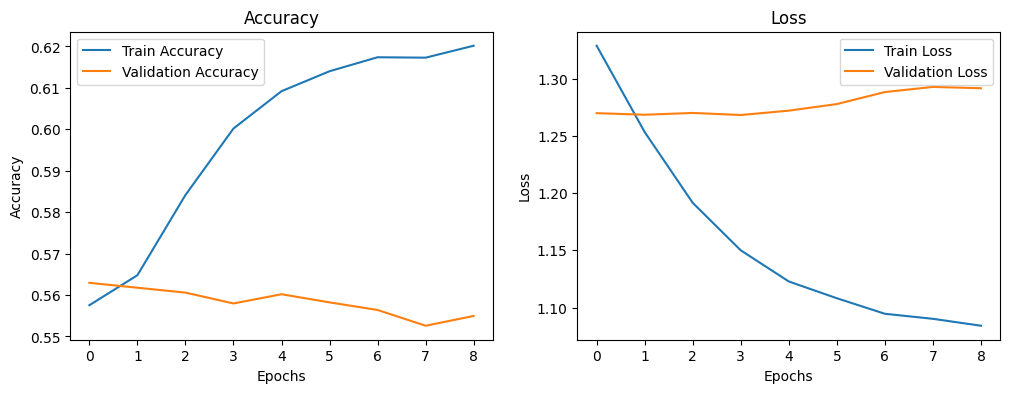

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.00      0.00      0.00       183
          기타       0.18      0.01      0.01       811
    농,어,임,광업       0.00      0.00      0.00        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.00      0.00      0.00       300
     정보처리S/W       0.26      0.02      0.04      1682
         제조업       0.57      0.98      0.72      4297

    accuracy                           0.56      7633
   macro avg       0.14      0.14      0.11      7633
weighted avg       0.39      0.56      0.41      7633


Confusion Matrix:
[[   0    2    0    0    0    2  179]
 [   0    5    0    0    0   17  789]
 [   0    0    0    0    0    0   35]
 [   0    0    0    0    0   14  311]
 [   0    2    0    0    0   10  288]
 [   0    2    0    0    0   36 1644]
 [   0   17    0    0    0   62 4218]]


In [12]:
loss, accuracy = model.evaluate(X_test_padded, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

In [12]:
def predict_new_company_simple_rnn(name_str):
    sequence = tokenizer.texts_to_sequences([name_str])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence_score = prediction[0][predicted_class_index]
    return predicted_class_label, confidence_score

# 테스트
new_company_name = "주식회사 트렌드잇플"
predicted_label, confidence = predict_new_company_simple_rnn(new_company_name)
print(f"\n업체명 '{new_company_name}'의 예측 업종 (SimpleRNN): {predicted_label} (신뢰도: {confidence:.2f})")

new_company_name_2 = "주식회사 스페이스비트"
predicted_label_2, confidence_2 = predict_new_company_simple_rnn(new_company_name_2)
print(f"업체명 '{new_company_name_2}'의 예측 업종 (SimpleRNN): {predicted_label_2} (신뢰도: {confidence_2:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

업체명 '주식회사 트렌드잇플'의 예측 업종 (SimpleRNN): 제조업 (신뢰도: 0.49)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
업체명 '주식회사 스페이스비트'의 예측 업종 (SimpleRNN): 제조업 (신뢰도: 0.49)


## 실험 2. 데이터 전처리 보완 (음절 단위 변환, 불필요한 텍스트 제거, class_weight)

In [88]:
import pandas as pd
df = pd.read_csv('./data/중소벤처기업부_벤처기업명단_20250228.csv')
df['업종분류(기보)'].unique()

df_selected = df[['업체명', '업종분류(기보)']].copy()
df_selected.dropna(subset=['업체명', '업종분류(기보)'], inplace=True)

target_categories = ['기타', '제조업', '정보처리S/W', '농,어,임,광업', '건설운수', '연구개발서비스', '도소매업']
df_filtered = df_selected[df_selected['업종분류(기보)'].isin(target_categories)].copy()
print(df_filtered['업종분류(기보)'].value_counts())

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_filtered['업종분류_encoded'] = label_encoder.fit_transform(df_filtered['업종분류(기보)'])

num_classes = len(label_encoder.classes_) # 7
# print(f"클래스 수: {num_classes}")

import re # 정규표현식 사용을 위해 임포트

patterns_to_remove = [
    
    r'\(\s*주\s*\)',  # (주) 및 괄호 내 공백 포함 형태
    r'\(주\)',       # (주) 형태
    r'주식회사\s*',    # '주식회사' 및 뒤따르는 공백
    '㈜',
    r'\s*주식회사',    # 앞 공백 포함 '주식회사'
    r'\(\s*유\s*\)',
    r'\(유\)',
    r'유한회사\s*',
    r'\s*유한회사',
]

# 패턴들을 하나의 정규표현식으로 결합
combined_pattern = '|'.join(patterns_to_remove)

# '업체명' 컬럼에 적용하여 패턴 제거
# 원본을 유지하고 싶으면 새 컬럼에 저장: df_filtered['업체명_정제'] = ...
df_filtered['업체명'] = df_filtered['업체명'].str.replace(combined_pattern, '', regex=True)

# 제거 후 앞뒤 공백 제거
df_filtered['업체명'] = df_filtered['업체명'].str.strip()

업종분류(기보)
제조업         21485
정보처리S/W      8409
기타           4057
도소매업         1624
연구개발서비스      1498
건설운수          914
농,어,임,광업      176
Name: count, dtype: int64


In [89]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X = df_filtered['업체명']
y = df_filtered['업종분류_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print(f"학습 데이터 수: {len(X_train)}")
print(f"테스트 데이터 수: {len(X_test)}")

X_train_chars = [' '.join(list(name)) for name in X_train]
X_test_chars = [' '.join(list(name)) for name in X_test]

# 음절 단위 분리
print(f'음절 단위 분리 >> {X_train_chars[0]}')

학습 데이터 수: 30530
테스트 데이터 수: 7633
음절 단위 분리 >> 에 이 피 에 너 지


In [90]:
# 2. Tokenizer 생성 및 학습 데이터에 맞게 단어 사전(문자 사전) 구축
# 여기서 num_words를 설정하지 않거나, 충분히 큰 값으로 설정하면 모든 고유 문자를 포함하게 됩니다.
# oov_token을 설정해주는 것이 좋습니다.
char_tokenizer = Tokenizer(oov_token="<OOV>") # char_level=False가 기본값이며, 공백으로 분리된 토큰을 학습합니다.
char_tokenizer.fit_on_texts(X_train_chars)

# 3. 실제 학습된 고유 문자의 수 확인
# char_tokenizer.word_index에는 학습된 각 문자(토큰)와 해당 정수 인덱스가 저장됩니다.
# <OOV> 토큰도 여기에 포함됩니다.
# 인덱스 0은 Keras에서 보통 패딩을 위해 사용되므로, Embedding 레이어의 input_dim은 보통 len(word_index) + 1이 됩니다.
actual_char_vocab_size = len(char_tokenizer.word_index) + 1
print(f"학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): {actual_char_vocab_size}")

# 4. 이 값을 Embedding 레이어의 input_dim으로 사용합니다.
# Tokenizer의 num_words 파라미터는 texts_to_sequences 시 고려할 단어 수 제한이므로,
# 모든 문자를 사용하려면 설정하지 않거나 위에서 계산된 actual_char_vocab_size보다 크거나 같게 설정할 수 있습니다.
# 명시적으로 Tokenizer에 num_words를 전달하고 싶다면:
# char_tokenizer = Tokenizer(num_words=actual_char_vocab_size, oov_token="<OOV>")
# char_tokenizer.fit_on_texts(X_train_chars) # 다시 fit할 필요는 없지만, 일관성을 위해 num_words를 미리 정하고 fit할 수도 있습니다.

# 5. 시퀀스 변환 및 패딩
X_train_sequences_char = char_tokenizer.texts_to_sequences(X_train_chars)
X_test_sequences_char = char_tokenizer.texts_to_sequences(X_test_chars)

학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): 1078


count    30530.000000
mean         5.223223
std          2.520574
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         35.000000
dtype: float64


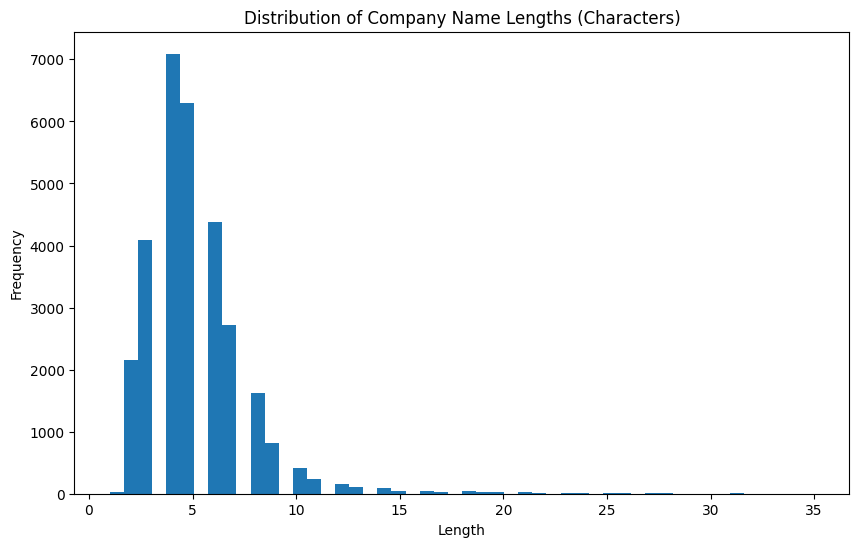

95th percentile length: 9


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sequence_lengths = [len(seq) for seq in X_train_sequences_char]

lengths_series = pd.Series(sequence_lengths)
print(lengths_series.describe()) # 통계치 확인 (평균, 표준편차, 최소, 최대, 사분위수 등)

plt.figure(figsize=(10, 6))
plt.hist(lengths_series, bins=50)
plt.title('Distribution of Company Name Lengths (Characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# 예: 95% 지점의 길이로 max_len 설정
# 최대 길이(Max Length): 가장 긴 업체명의 길이를 max_len으로 설정할 경우 정보 손실은 없지만, 
# 대부분의 업체명이 이보다 훨씬 짧다면 불필요한 패딩이 많아져 비효율적일 수 있고, 극단적으로 긴 업체명 하나 때문에 max_len이 너무 커질 수도 있습니다.
chosen_max_len = int(np.percentile(sequence_lengths, 95))
print(f"95th percentile length: {chosen_max_len}")

# 음절 단위에 맞는 max_len 재설정 (95%구간이 13자로  여유롭게 20자로 선정. 실험을 통해 적절한 값 조정이 필요함)
char_max_len = 15

# padding 파라미터는 원본 시퀀스의 길이가 maxlen보다 짧을 경우, 어느 위치에 채워넣기(padding, 보통 0으로 채움)를 할지 결정합니다.
# 'post'는 "뒤에(after)"라는 의미로 원본 시퀀스 내용 뒤에, 즉 시퀀스의 끝부분에 0을 채워 넣어 maxlen 길이를 맞춥니다.
# truncating 파라미터는 원본 시퀀스의 길이가 maxlen보다 길 경우, 어느 위치의 값을 잘라낼지(truncating) 결정합니다.
# 'post'는 "뒤에서부터(from the end)"라는 의미로, 원본 시퀀스의 끝부분부터 초과하는 길이만큼 잘라내어 maxlen 길이를 맞춥니다. 즉, 시퀀스의 앞부분이 보존됩니다.
X_train_padded_char = pad_sequences(X_train_sequences_char, maxlen=char_max_len, padding='post', truncating='post')
X_test_padded_char = pad_sequences(X_test_sequences_char, maxlen=char_max_len, padding='post', truncating='post')

# 6. 모델의 Embedding 레이어 설정
# model.add(Embedding(input_dim=actual_char_vocab_size, output_dim=embedding_dim, input_length=char_max_len))

In [49]:
# 모델 구조는 Baseline 그대로 사용 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

embedding_dim = 64
hidden_units = 64

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])


model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

history = model.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50


2025-05-12 15:57:53.431208: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


478/478 - 2s - 4ms/step - accuracy: 0.5630 - loss: 1.2784 - val_accuracy: 0.5983 - val_loss: 1.1527
Epoch 2/50
478/478 - 1s - 2ms/step - accuracy: 0.5932 - loss: 1.1695 - val_accuracy: 0.5950 - val_loss: 1.1392
Epoch 3/50
478/478 - 1s - 2ms/step - accuracy: 0.6056 - loss: 1.1296 - val_accuracy: 0.5926 - val_loss: 1.1309
Epoch 4/50
478/478 - 1s - 2ms/step - accuracy: 0.6116 - loss: 1.1057 - val_accuracy: 0.5991 - val_loss: 1.1251
Epoch 5/50
478/478 - 1s - 2ms/step - accuracy: 0.6197 - loss: 1.0865 - val_accuracy: 0.5947 - val_loss: 1.1346
Epoch 6/50
478/478 - 1s - 2ms/step - accuracy: 0.6243 - loss: 1.0737 - val_accuracy: 0.5918 - val_loss: 1.1386
Epoch 7/50
478/478 - 1s - 2ms/step - accuracy: 0.6261 - loss: 1.0594 - val_accuracy: 0.5928 - val_loss: 1.1489
Epoch 8/50
478/478 - 1s - 2ms/step - accuracy: 0.6307 - loss: 1.0470 - val_accuracy: 0.5960 - val_loss: 1.1490
Epoch 9/50
478/478 - 1s - 2ms/step - accuracy: 0.6359 - loss: 1.0314 - val_accuracy: 0.5898 - val_loss: 1.1517
Epoch 9: ear

2025-05-12 15:58:05.702218: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 1.1251
Test Accuracy: 0.5991


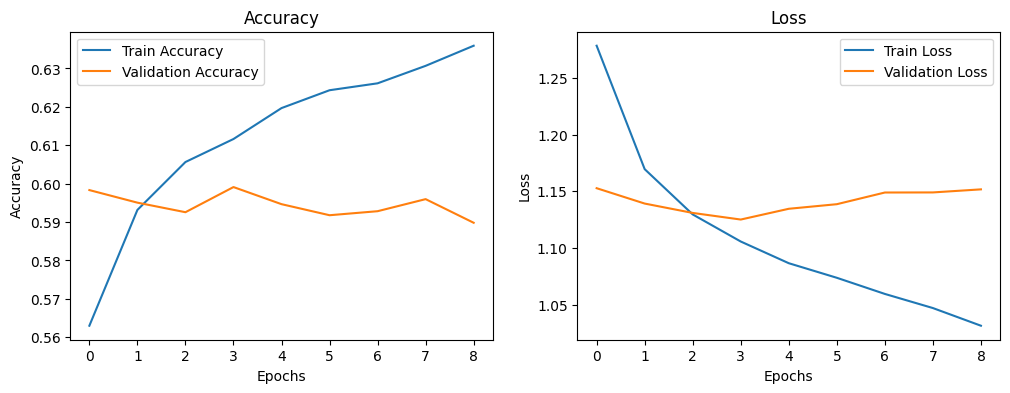

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.00      0.00      0.00       183
          기타       0.51      0.05      0.08       811
    농,어,임,광업       0.00      0.00      0.00        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.61      0.06      0.11       300
     정보처리S/W       0.44      0.50      0.47      1682
         제조업       0.65      0.85      0.74      4297

    accuracy                           0.60      7633
   macro avg       0.32      0.21      0.20      7633
weighted avg       0.54      0.60      0.53      7633


Confusion Matrix:
[[   0    1    0    0    2   23  157]
 [   0   37    0    0    3  271  500]
 [   0    1    0    0    0    1   33]
 [   0    3    0    0    0  115  207]
 [   0    3    0    0   19   53  225]
 [   0   12    0    0    1  844  825]
 [   0   16    0    0    6  602 3673]]


In [51]:
loss, accuracy = model.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### class_weight 적용

In [52]:
from sklearn.utils import class_weight
class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights_list))
print("계산된 클래스 가중치:", class_weight_dict)

계산된 클래스 가중치: {0: np.float64(5.966386554621849), 1: np.float64(1.343631722559634), 2: np.float64(30.932117527862207), 3: np.float64(3.357527768613219), 4: np.float64(3.64059146196041), 5: np.float64(0.6483467476480707), 6: np.float64(0.253748462382393)}


In [53]:
# 모델 구조는 Baseline 그대로 사용 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

embedding_dim = 64
hidden_units = 64

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])

model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

history = model.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks = [early_stopping],
    class_weight=class_weight_dict,
    verbose=2
)

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-05-12 16:04:58.469277: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


478/478 - 2s - 4ms/step - accuracy: 0.1678 - loss: 1.8544 - val_accuracy: 0.1707 - val_loss: 1.8218
Epoch 2/50
478/478 - 1s - 2ms/step - accuracy: 0.1581 - loss: 1.7402 - val_accuracy: 0.1820 - val_loss: 1.8346
Epoch 3/50
478/478 - 1s - 2ms/step - accuracy: 0.1649 - loss: 1.6627 - val_accuracy: 0.1849 - val_loss: 1.8380
Epoch 4/50
478/478 - 1s - 2ms/step - accuracy: 0.1653 - loss: 1.6074 - val_accuracy: 0.2099 - val_loss: 1.7693
Epoch 5/50
478/478 - 1s - 2ms/step - accuracy: 0.1667 - loss: 1.5754 - val_accuracy: 0.1676 - val_loss: 1.8030
Epoch 6/50
478/478 - 1s - 2ms/step - accuracy: 0.1655 - loss: 1.5138 - val_accuracy: 0.2059 - val_loss: 1.8018
Epoch 7/50
478/478 - 1s - 2ms/step - accuracy: 0.1670 - loss: 1.5146 - val_accuracy: 0.1807 - val_loss: 1.7990
Epoch 8/50
478/478 - 1s - 2ms/step - accuracy: 0.1745 - loss: 1.4541 - val_accuracy: 0.1732 - val_loss: 1.8086
Epoch 9/50
478/478 - 1s - 2ms/step - accuracy: 0.1742 - loss: 1.4579 - val_accuracy: 0.1949 - val_loss: 1.7772
Epoch 9: ear

2025-05-12 16:05:09.079364: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 1.7693
Test Accuracy: 0.2099


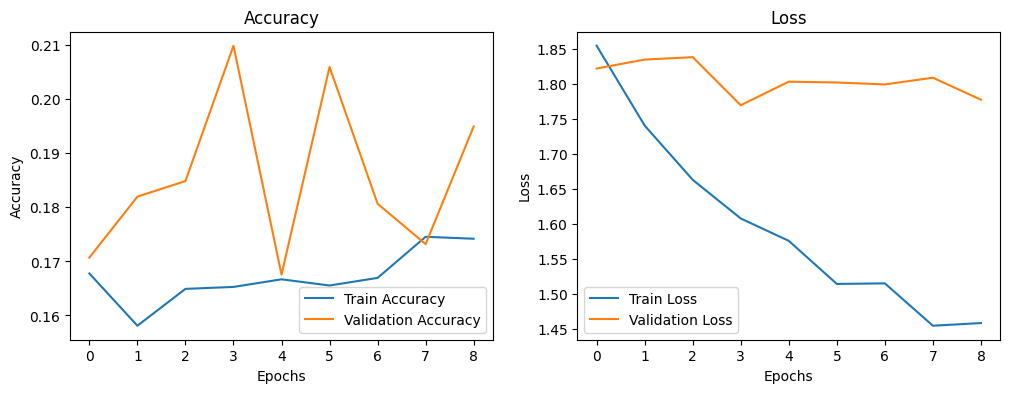

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.05      0.54      0.10       183
          기타       0.10      0.05      0.07       811
    농,어,임,광업       0.05      0.43      0.08        35
        도소매업       0.06      0.01      0.02       325
     연구개발서비스       0.16      0.35      0.22       300
     정보처리S/W       0.30      0.75      0.43      1682
         제조업       0.62      0.02      0.04      4297

    accuracy                           0.21      7633
   macro avg       0.19      0.31      0.14      7633
weighted avg       0.44      0.21      0.13      7633


Confusion Matrix:
[[  99   11    5    1    3   59    5]
 [ 171   42   23    9   50  502   14]
 [   2    2   15    0    5   10    1]
 [  29   19   12    4   40  217    4]
 [  33   15   16    3  105  125    3]
 [ 153   69   48   14  119 1256   23]
 [1403  268  202   32  335 1976   81]]


In [54]:
loss, accuracy = model.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### Focal Loss 적용

In [56]:
import tensorflow as tf
import tensorflow.keras.backend as K

def categorical_focal_loss(gamma=2.0, alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon() # 작은 값을 더해 log(0) 방지
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon) # 예측값을 범위 내로 클리핑

        # y_true를 y_pred와 동일한 float 타입으로 변환
        y_true_c = tf.cast(y_true, dtype=y_pred.dtype)

        # 1. p_t 계산: 실제 정답 클래스에 대한 모델의 예측 확률
        # y_true가 원-핫 인코딩 되어 있으므로, 곱한 후 합하면 정답 클래스의 예측 확률만 남음
        p_t = K.sum(y_true_c * y_pred, axis=-1) # 각 샘플에 대한 정답 클래스의 확률, Shape: (batch_size,)

        # 2. 표준 Cross Entropy 계산 (정답 클래스에 대해서만)
        ce = -K.log(p_t + epsilon) # Shape: (batch_size,)

        # 3. Modulating Factor (집중 조절 인자) 계산
        modulating_factor = K.pow(1. - p_t, gamma) # Shape: (batch_size,)
        
        # 4. Focal Loss 계산
        focal_loss_ = modulating_factor * ce # Shape: (batch_size,)

        # 5. Alpha (클래스 가중치 인자) 적용
        if alpha is not None:
            if isinstance(alpha, (list, tuple, np.ndarray)): # alpha가 클래스별 가중치 리스트/배열인 경우
                alpha_weights = K.constant(np.array(alpha, dtype=K.floatx()))
                # 정답 클래스에 해당하는 alpha 가중치 선택
                alpha_factor = K.sum(y_true_c * alpha_weights, axis=-1) # Shape: (batch_size,)
                focal_loss_ = alpha_factor * focal_loss_
            else: # alpha가 스칼라 값인 경우 (모든 클래스에 동일한 가중치 적용)
                focal_loss_ = alpha * focal_loss_
                
        return K.mean(focal_loss_) # 배치 전체에 대한 평균 손실 반환
    return focal_loss_fixed

In [57]:
embedding_dim = 64
hidden_units = 64

model_focal = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])


model_focal.summary()

# 모델 컴파일: Focal Loss 사용
# gamma는 보통 2.0을 많이 사용. alpha는 클래스 가중치 역할을 하며,
# None으로 두면 focal_loss_ 함수 내부에서 alpha 적용 부분이 스킵됩니다.
# 또는 alpha=1.0 (스칼라)로 설정할 수도 있습니다. 여기서는 alpha=None으로 설정하여 gamma의 효과만 보겠습니다.
gamma_value = 2.0 # Focal Loss의 gamma 값 (튜닝 가능)
# alpha_value = None # 클래스 가중치 효과 없이 gamma의 focusing 효과만 보려면
alpha_value = 0.25 # 논문에서 자주 사용되는 스칼라 값 (모든 클래스에 동일하게 적용되어 클래스별 가중 효과는 약함)
                   # 또는 alpha_value = [1.0] * num_classes # 모든 클래스에 동일 가중치 1.0

optimizer = Adam(learning_rate=0.001)
model_focal.compile(optimizer=optimizer, 
                    loss=categorical_focal_loss(gamma=gamma_value, alpha=alpha_value), # <--- 변경점: Focal Loss 적용
                    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---")
history_focal = model_focal.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    # class_weight는 사용하지 않음
    verbose=2
)

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---
Epoch 1/50


2025-05-12 16:08:56.357360: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


478/478 - 2s - 4ms/step - accuracy: 0.5523 - loss: 0.1989 - val_accuracy: 0.5945 - val_loss: 0.1747
Epoch 2/50
478/478 - 1s - 2ms/step - accuracy: 0.5825 - loss: 0.1767 - val_accuracy: 0.5954 - val_loss: 0.1685
Epoch 3/50
478/478 - 1s - 2ms/step - accuracy: 0.5912 - loss: 0.1682 - val_accuracy: 0.5922 - val_loss: 0.1675
Epoch 4/50
478/478 - 1s - 2ms/step - accuracy: 0.5994 - loss: 0.1627 - val_accuracy: 0.6020 - val_loss: 0.1654
Epoch 5/50
478/478 - 1s - 2ms/step - accuracy: 0.6003 - loss: 0.1591 - val_accuracy: 0.5940 - val_loss: 0.1673
Epoch 6/50
478/478 - 1s - 2ms/step - accuracy: 0.6067 - loss: 0.1556 - val_accuracy: 0.5945 - val_loss: 0.1706
Epoch 7/50
478/478 - 1s - 2ms/step - accuracy: 0.6098 - loss: 0.1526 - val_accuracy: 0.5920 - val_loss: 0.1704
Epoch 8/50
478/478 - 1s - 2ms/step - accuracy: 0.6136 - loss: 0.1499 - val_accuracy: 0.5894 - val_loss: 0.1710
Epoch 9/50
478/478 - 1s - 2ms/step - accuracy: 0.6130 - loss: 0.1472 - val_accuracy: 0.5907 - val_loss: 0.1736
Epoch 9: ear

2025-05-12 16:10:20.735086: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.1654
Test Accuracy: 0.6020


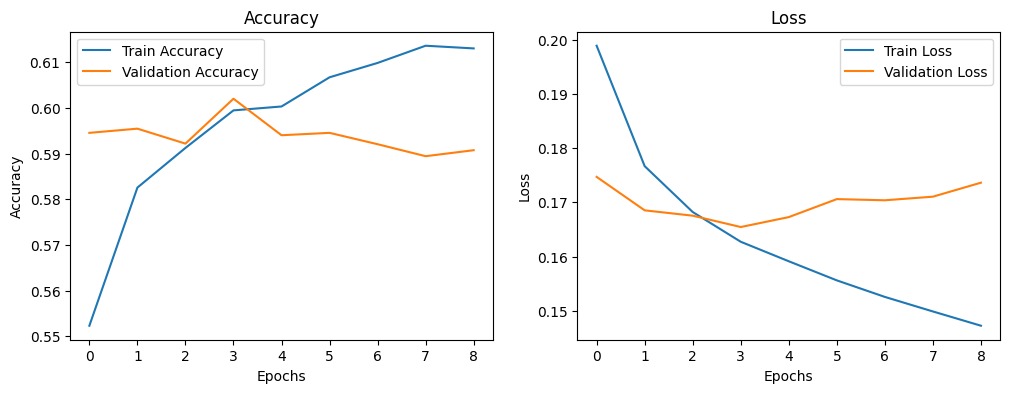

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.00      0.00      0.00       183
          기타       0.50      0.02      0.04       811
    농,어,임,광업       0.00      0.00      0.00        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.62      0.08      0.14       300
     정보처리S/W       0.46      0.42      0.44      1682
         제조업       0.64      0.90      0.74      4297

    accuracy                           0.60      7633
   macro avg       0.32      0.20      0.19      7633
weighted avg       0.54      0.60      0.53      7633


Confusion Matrix:
[[   0    0    0    0    0   17  166]
 [   0   16    0    0    3  238  554]
 [   0    1    0    0    0    1   33]
 [   0    1    0    0    1   85  238]
 [   0    3    0    0   23   48  226]
 [   0    5    0    0    2  710  965]
 [   0    6    0    0    8  437 3846]]


In [59]:
loss, accuracy = model_focal.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_focal.history['accuracy'], label='Train Accuracy')
plt.plot(history_focal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_focal.history['loss'], label='Train Loss')
plt.plot(history_focal.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_focal.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### Focal loss + class_weight(alpha)

In [62]:
embedding_dim = 64
hidden_units = 64

model_focal = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])

model_focal.summary()


# 모델 컴파일: Focal Loss 사용
gamma_value = 2.0 # Focal Loss의 gamma 값 (튜닝 가능)

optimizer = Adam(learning_rate=0.001)

class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# 클래스 인덱스에 맞춰 리스트 생성 (만약 compute_class_weight가 정렬된 클래스 순서로 반환한다면)
# 또는 딕셔너리 생성 후 리스트 변환
class_weight_dict = dict(enumerate(class_weights_list))

cw = {i: w for i, w in class_weight_dict.items()}
total = sum(cw.values())
factor = len(cw) / total
normalized_cw = {i: float(w * factor) for i, w in cw.items()}

sqrt_cw = {i: float(np.sqrt(w)) 
           for i, w in normalized_cw.items()}
alpha_values = [sqrt_cw.get(i, 1.0) for i in range(num_classes)]

model_focal.compile(optimizer=optimizer, 
                    loss=categorical_focal_loss(gamma=gamma_value, alpha=alpha_values), # <--- 변경점: Focal Loss 적용
                    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---")
history_focal = model_focal.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    # class_weight는 사용하지 않음
    verbose=2
)

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---
Epoch 1/50


2025-05-12 16:12:38.389577: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


478/478 - 2s - 4ms/step - accuracy: 0.5019 - loss: 0.3727 - val_accuracy: 0.5274 - val_loss: 0.3434
Epoch 2/50
478/478 - 1s - 2ms/step - accuracy: 0.5224 - loss: 0.3435 - val_accuracy: 0.5149 - val_loss: 0.3383
Epoch 3/50
478/478 - 1s - 2ms/step - accuracy: 0.5348 - loss: 0.3275 - val_accuracy: 0.5309 - val_loss: 0.3363
Epoch 4/50
478/478 - 1s - 2ms/step - accuracy: 0.5310 - loss: 0.3143 - val_accuracy: 0.5326 - val_loss: 0.3349
Epoch 5/50
478/478 - 1s - 2ms/step - accuracy: 0.5358 - loss: 0.3062 - val_accuracy: 0.5214 - val_loss: 0.3404
Epoch 6/50
478/478 - 1s - 2ms/step - accuracy: 0.5241 - loss: 0.3093 - val_accuracy: 0.5404 - val_loss: 0.3433
Epoch 7/50
478/478 - 1s - 2ms/step - accuracy: 0.5308 - loss: 0.3067 - val_accuracy: 0.5369 - val_loss: 0.3430
Epoch 8/50
478/478 - 1s - 2ms/step - accuracy: 0.5410 - loss: 0.2909 - val_accuracy: 0.5071 - val_loss: 0.3465
Epoch 9/50
478/478 - 1s - 2ms/step - accuracy: 0.5396 - loss: 0.2828 - val_accuracy: 0.5222 - val_loss: 0.3561
Epoch 9: ear

2025-05-12 16:12:51.864688: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.3349
Test Accuracy: 0.5326


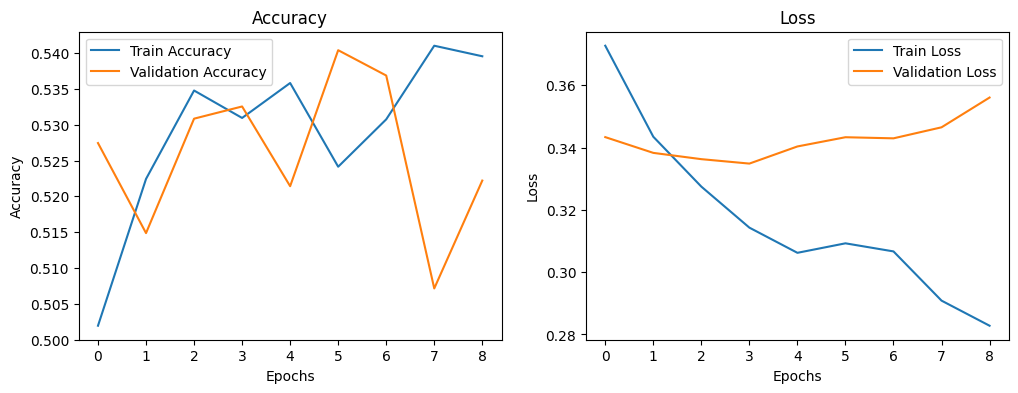

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.21      0.13      0.16       183
          기타       0.29      0.01      0.01       811
    농,어,임,광업       0.14      0.29      0.19        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.36      0.24      0.29       300
     정보처리S/W       0.37      0.66      0.47      1682
         제조업       0.68      0.66      0.67      4297

    accuracy                           0.53      7633
   macro avg       0.29      0.28      0.26      7633
weighted avg       0.51      0.53      0.50      7633


Confusion Matrix:
[[  23    0    0    0    3   31  126]
 [  16    6    1    0   12  385  391]
 [   0    0   10    0    3    7   15]
 [   1    0    6    0    4  162  152]
 [   1    0    3    0   71  108  117]
 [   0    4    0    0   11 1103  564]
 [  69   11   49    0   91 1225 2852]]


In [63]:
loss, accuracy = model_focal.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_focal.history['accuracy'], label='Train Accuracy')
plt.plot(history_focal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_focal.history['loss'], label='Train Loss')
plt.plot(history_focal.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_focal.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### 모델 구조 개선 Bidirectional RNN

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional # Bidirectional 임포트
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 하이퍼파라미터 설정
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()

# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          loss='categorical_crossentropy', # 또는 focal loss
                          # loss=categorical_focal_loss(gamma=2.0, alpha=[1.0]*num_classes), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-13 14:06:05.473168: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-13 14:06:11.267134: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

475/475 - 7s - 14ms/step - accuracy: 0.6486 - loss: 1.1422 - val_accuracy: 0.7393 - val_loss: 0.8618
Epoch 2/50
475/475 - 5s - 10ms/step - accuracy: 0.7429 - loss: 0.8954 - val_accuracy: 0.7551 - val_loss: 0.8147
Epoch 3/50
475/475 - 5s - 11ms/step - accuracy: 0.7605 - loss: 0.8313 - val_accuracy: 0.7596 - val_loss: 0.7869
Epoch 4/50
475/475 - 5s - 11ms/step - accuracy: 0.7658 - loss: 0.8007 - val_accuracy: 0.7571 - val_loss: 0.8020
Epoch 5/50
475/475 - 5s - 11ms/step - accuracy: 0.7709 - loss: 0.7821 - val_accuracy: 0.7614 - val_loss: 0.7855
Epoch 6/50
475/475 - 5s - 11ms/step - accuracy: 0.7774 - loss: 0.7526 - val_accuracy: 0.7631 - val_loss: 0.7805
Epoch 7/50
475/475 - 5s - 11ms/step - accuracy: 0.7823 - loss: 0.7414 - val_accuracy: 0.7598 - val_loss: 0.7946
Epoch 8/50
475/475 - 5s - 11ms/step - accuracy: 0.7865 - loss: 0.7154 - val_accuracy: 0.7582 - val_loss: 0.7900
Epoch 9/50
475/475 - 5s - 11ms/step - accuracy: 0.7879 - loss: 0.7023 - val_accuracy: 0.7677 - val_loss: 0.7696
Epo

2025-05-12 17:04:33.483100: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 1.1105
Test Accuracy: 0.6058


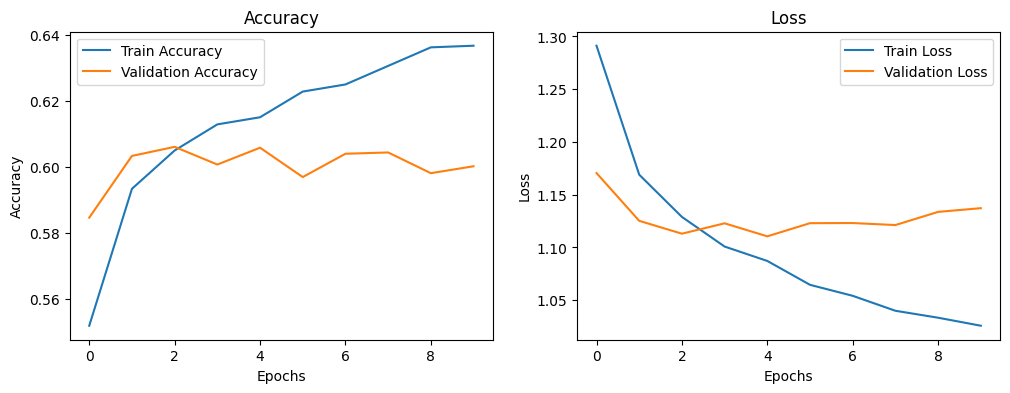

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.00      0.00      0.00       183
          기타       0.42      0.10      0.16       811
    농,어,임,광업       0.00      0.00      0.00        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.55      0.13      0.21       300
     정보처리S/W       0.46      0.46      0.46      1682
         제조업       0.66      0.87      0.75      4297

    accuracy                           0.61      7633
   macro avg       0.30      0.22      0.22      7633
weighted avg       0.54      0.61      0.55      7633


Confusion Matrix:
[[   0    8    0    0    0   17  158]
 [   0   79    0    0    6  227  499]
 [   0    1    0    0    0    2   32]
 [   0    6    0    0    3  106  210]
 [   0    7    0    0   38   56  199]
 [   0   49    0    0    2  769  862]
 [   0   40    0    0   20  499 3738]]


In [80]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

In [185]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 음절(문자) 단위 전처리를 수행하는 예측 함수
def predict_company_char_rnn(name_str, tokenizer, max_len, model_to_predict, label_encoder_obj):
    
    # 1. 입력된 업체명을 음절(문자) 단위로 분리하고 공백으로 연결
    #    (char_tokenizer가 이 형태의 데이터로 fit되었다고 가정)
    processed_name = ' '.join(list(name_str))

    # 2. Tokenizer를 사용하여 정수 시퀀스로 변환
    sequence = tokenizer.texts_to_sequences([processed_name])

    # 3. 패딩 적용 (학습 시와 동일한 max_len, padding, truncating 사용)
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 4. 모델 예측 수행
    prediction_probs = model_to_predict.predict(padded_sequence)

    # 5. 가장 높은 확률을 가진 클래스 인덱스 찾기
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # 6. 예측된 클래스 인덱스를 실제 라벨명으로 변환
    predicted_class_label = label_encoder_obj.inverse_transform([predicted_class_index])[0]

    # 7. 해당 예측의 신뢰도(확률) 추출
    confidence_score = prediction_probs[0][predicted_class_index]

    return predicted_class_label, confidence_score

try:
    new_company_name = "로코모스튜디오"
    # 올바른 객체 전달: char_tokenizer, char_max_len, 학습된 모델, label_encoder
    predicted_label, confidence = predict_company_char_rnn(
        new_company_name,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"\n업체명 '{new_company_name}'의 예측 업종: {predicted_label} (신뢰도: {confidence:.2f})")

    new_company_name_2 = "엔글링크"
    predicted_label_2, confidence_2 = predict_company_char_rnn(
        new_company_name_2,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"업체명 '{new_company_name_2}'의 예측 업종: {predicted_label_2} (신뢰도: {confidence_2:.2f})")

except NameError as e:
    print(f"\n오류: 예측 함수 실행에 필요한 객체({e})가 정의되지 않았습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

업체명 '로코모스튜디오'의 예측 업종: 기타 (신뢰도: 0.32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
업체명 '엔글링크'의 예측 업종: 제조업 (신뢰도: 0.42)


### 양방향 RNN Focal loss

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional # Bidirectional 임포트
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 하이퍼파라미터 설정
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

# 모델 정의: Stacked Bidirectional SimpleRNN
model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()

class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# 클래스 인덱스에 맞춰 리스트 생성 (만약 compute_class_weight가 정렬된 클래스 순서로 반환한다면)
# 또는 딕셔너리 생성 후 리스트 변환
class_weight_dict = dict(enumerate(class_weights_list))

cw = {i: w for i, w in class_weight_dict.items()}
total = sum(cw.values())
factor = len(cw) / total
normalized_cw = {i: float(w * factor) for i, w in cw.items()}

sqrt_cw = {i: float(np.sqrt(w)) 
           for i, w in normalized_cw.items()}
alpha_values = [sqrt_cw.get(i, 1.0) for i in range(num_classes)]

# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          loss=categorical_focal_loss(gamma=2.0, alpha=alpha_values), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-12 17:53:19.044584: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


478/478 - 5s - 10ms/step - accuracy: 0.4693 - loss: 0.3836 - val_accuracy: 0.5630 - val_loss: 0.3454
Epoch 2/50
478/478 - 2s - 5ms/step - accuracy: 0.5252 - loss: 0.3424 - val_accuracy: 0.5385 - val_loss: 0.3296
Epoch 3/50
478/478 - 2s - 5ms/step - accuracy: 0.5350 - loss: 0.3248 - val_accuracy: 0.5421 - val_loss: 0.3266
Epoch 4/50
478/478 - 2s - 5ms/step - accuracy: 0.5382 - loss: 0.3128 - val_accuracy: 0.5402 - val_loss: 0.3299
Epoch 5/50
478/478 - 2s - 5ms/step - accuracy: 0.5467 - loss: 0.3070 - val_accuracy: 0.5434 - val_loss: 0.3270
Epoch 6/50
478/478 - 2s - 5ms/step - accuracy: 0.5508 - loss: 0.2942 - val_accuracy: 0.5616 - val_loss: 0.3318
Epoch 7/50
478/478 - 2s - 5ms/step - accuracy: 0.5516 - loss: 0.2885 - val_accuracy: 0.5440 - val_loss: 0.3317
Epoch 8/50
478/478 - 2s - 5ms/step - accuracy: 0.5532 - loss: 0.2836 - val_accuracy: 0.5443 - val_loss: 0.3354
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
--- 모델 학습 종료 ---



2025-05-12 17:53:46.351047: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.3266
Test Accuracy: 0.5421


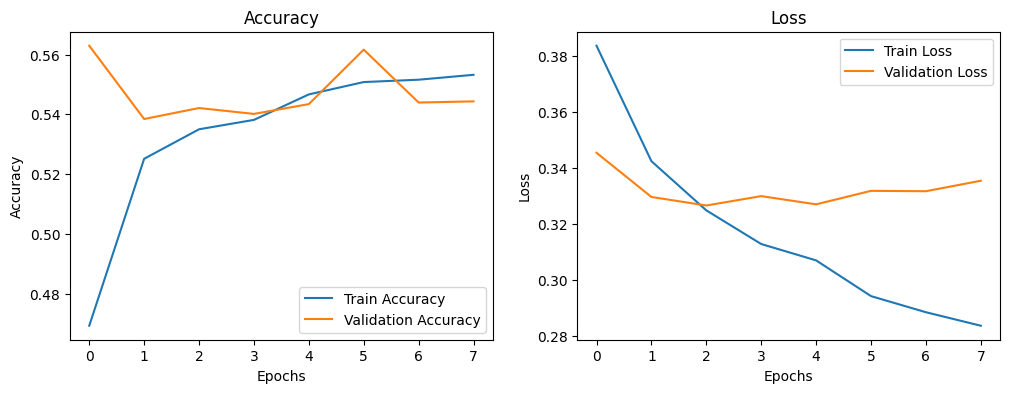

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.20      0.17      0.18       183
          기타       0.32      0.07      0.12       811
    농,어,임,광업       0.14      0.29      0.19        35
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.38      0.26      0.31       300
     정보처리S/W       0.38      0.64      0.47      1682
         제조업       0.69      0.67      0.68      4297

    accuracy                           0.54      7633
   macro avg       0.30      0.30      0.28      7633
weighted avg       0.53      0.54      0.52      7633


Confusion Matrix:
[[  32    7    0    0    1   30  113]
 [  18   60    1    0   16  383  333]
 [   0    2   10    0    2    6   15]
 [   3    8    6    0    5  157  146]
 [   1   11    2    0   78  107  101]
 [   1   34    0    0   11 1075  561]
 [ 109   66   53    0   91 1095 2883]]


In [93]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

In [206]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 음절(문자) 단위 전처리를 수행하는 예측 함수
def predict_company_char_rnn(name_str, tokenizer, max_len, model_to_predict, label_encoder_obj):
    
    # 1. 입력된 업체명을 음절(문자) 단위로 분리하고 공백으로 연결
    #    (char_tokenizer가 이 형태의 데이터로 fit되었다고 가정)
    processed_name = ' '.join(list(name_str))

    # 2. Tokenizer를 사용하여 정수 시퀀스로 변환
    sequence = tokenizer.texts_to_sequences([processed_name])

    # 3. 패딩 적용 (학습 시와 동일한 max_len, padding, truncating 사용)
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 4. 모델 예측 수행
    prediction_probs = model_to_predict.predict(padded_sequence)

    # 5. 가장 높은 확률을 가진 클래스 인덱스 찾기
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # 6. 예측된 클래스 인덱스를 실제 라벨명으로 변환
    predicted_class_label = label_encoder_obj.inverse_transform([predicted_class_index])[0]

    # 7. 해당 예측의 신뢰도(확률) 추출
    confidence_score = prediction_probs[0][predicted_class_index]

    return predicted_class_label, confidence_score

try:
    new_company_name = "보국에너텍"
    # 올바른 객체 전달: char_tokenizer, char_max_len, 학습된 모델, label_encoder
    predicted_label, confidence = predict_company_char_rnn(
        new_company_name,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"\n업체명 '{new_company_name}'의 예측 업종: {predicted_label} (신뢰도: {confidence:.2f})")

    new_company_name_2 = "마테리아노바코리아"
    predicted_label_2, confidence_2 = predict_company_char_rnn(
        new_company_name_2,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"업체명 '{new_company_name_2}'의 예측 업종: {predicted_label_2} (신뢰도: {confidence_2:.2f})")

except NameError as e:
    print(f"\n오류: 예측 함수 실행에 필요한 객체({e})가 정의되지 않았습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

업체명 '보국에너텍'의 예측 업종: 제조업 (신뢰도: 0.48)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
업체명 '마테리아노바코리아'의 예측 업종: 제조업 (신뢰도: 0.39)


### 소수 클래스 오버 샘플링

In [81]:
from imblearn.over_sampling import RandomOverSampler # 또는 SMOTE (텍스트에는 RandomOverSampler가 간단)

ros = RandomOverSampler(random_state=SEED) # SEED는 시드 고정값
try:
    # X_train을 NumPy 배열로 변환 후 reshape
    X_train_reshaped = X_train.values.reshape(-1, 1)
    X_train_resampled_np, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)

    # 결과 확인: 오버샘플링 후 클래스 분포 출력
    print(f"오버샘플링 후 학습 데이터 수: {len(X_train_resampled_np)}")
    print(f"오버샘플링 후 학습 데이터 클래스 분포:\n{pd.Series(y_train_resampled).value_counts().sort_index()}")

    # 3. 오버샘플링된 X 데이터를 다시 1D 형태로 변환 (Tokenizer 입력 준비)
    #    pandas Series로 변환하거나 NumPy 배열의 flatten() 사용 가능
    X_train_resampled = pd.Series(X_train_resampled_np.ravel())
    print("--- RandomOverSampler 적용 완료 ---")

except Exception as e:
    print(f"RandomOverSampler 적용 중 오류 발생: {e}")
    print("오버샘플링 없이 원본 데이터를 사용합니다.")
    # 오류 발생 시 원본 데이터 사용하도록 변수명 맞춰주기 (선택적)
    X_train_resampled = X_train
    y_train_resampled = y_train
# ---------------------------


오버샘플링 후 학습 데이터 수: 120316
오버샘플링 후 학습 데이터 클래스 분포:
업종분류_encoded
0    17188
1    17188
2    17188
3    17188
4    17188
5    17188
6    17188
Name: count, dtype: int64
--- RandomOverSampler 적용 완료 ---


음절 단위 분리 >> 에 이 피 에 너 지
학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): 1078
count    120316.000000
mean          5.703913
std           2.794308
min           1.000000
25%           4.000000
50%           5.000000
75%           7.000000
max          35.000000
dtype: float64


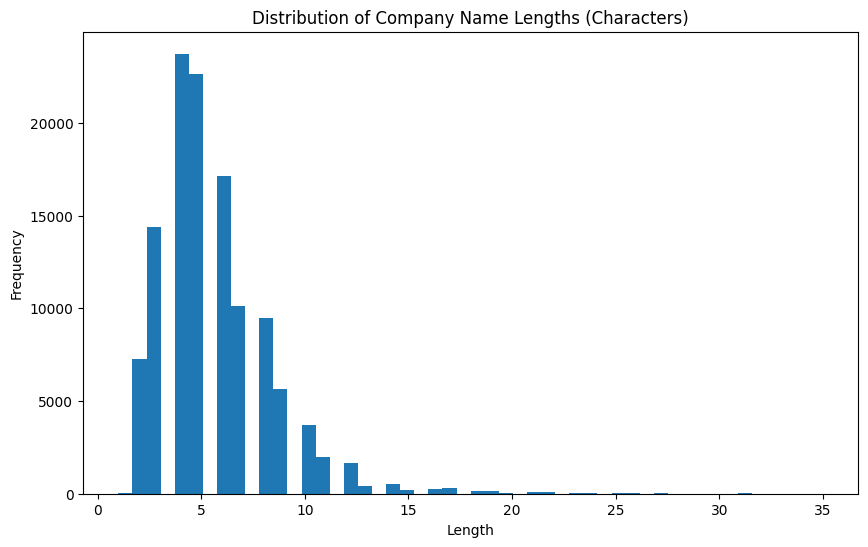

95th percentile length: 11


In [82]:
y_train_one_hot = to_categorical(y_train_resampled, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

X_train_chars = [' '.join(list(name)) for name in X_train_resampled]
X_test_chars = [' '.join(list(name)) for name in X_test]

# 음절 단위 분리
print(f'음절 단위 분리 >> {X_train_chars[0]}')

# 2. Tokenizer 생성 및 학습 데이터에 맞게 단어 사전(문자 사전) 구축
# 여기서 num_words를 설정하지 않거나, 충분히 큰 값으로 설정하면 모든 고유 문자를 포함하게 됩니다.
# oov_token을 설정해주는 것이 좋습니다.
char_tokenizer = Tokenizer(oov_token="<OOV>") # char_level=False가 기본값이며, 공백으로 분리된 토큰을 학습합니다.
char_tokenizer.fit_on_texts(X_train_chars)

# 3. 실제 학습된 고유 문자의 수 확인
# char_tokenizer.word_index에는 학습된 각 문자(토큰)와 해당 정수 인덱스가 저장됩니다.
# <OOV> 토큰도 여기에 포함됩니다.
# 인덱스 0은 Keras에서 보통 패딩을 위해 사용되므로, Embedding 레이어의 input_dim은 보통 len(word_index) + 1이 됩니다.
actual_char_vocab_size = len(char_tokenizer.word_index) + 1
print(f"학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): {actual_char_vocab_size}")

# 4. 이 값을 Embedding 레이어의 input_dim으로 사용합니다.
# Tokenizer의 num_words 파라미터는 texts_to_sequences 시 고려할 단어 수 제한이므로,
# 모든 문자를 사용하려면 설정하지 않거나 위에서 계산된 actual_char_vocab_size보다 크거나 같게 설정할 수 있습니다.
# 명시적으로 Tokenizer에 num_words를 전달하고 싶다면:
# char_tokenizer = Tokenizer(num_words=actual_char_vocab_size, oov_token="<OOV>")
# char_tokenizer.fit_on_texts(X_train_chars) # 다시 fit할 필요는 없지만, 일관성을 위해 num_words를 미리 정하고 fit할 수도 있습니다.

# 5. 시퀀스 변환 및 패딩
X_train_sequences_char = char_tokenizer.texts_to_sequences(X_train_chars)
X_test_sequences_char = char_tokenizer.texts_to_sequences(X_test_chars)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sequence_lengths = [len(seq) for seq in X_train_sequences_char]

lengths_series = pd.Series(sequence_lengths)
print(lengths_series.describe()) # 통계치 확인 (평균, 표준편차, 최소, 최대, 사분위수 등)

plt.figure(figsize=(10, 6))
plt.hist(lengths_series, bins=50)
plt.title('Distribution of Company Name Lengths (Characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# 예: 95% 지점의 길이로 max_len 설정
# 최대 길이(Max Length): 가장 긴 업체명의 길이를 max_len으로 설정할 경우 정보 손실은 없지만, 
# 대부분의 업체명이 이보다 훨씬 짧다면 불필요한 패딩이 많아져 비효율적일 수 있고, 극단적으로 긴 업체명 하나 때문에 max_len이 너무 커질 수도 있습니다.
chosen_max_len = int(np.percentile(sequence_lengths, 95))
print(f"95th percentile length: {chosen_max_len}")

# 음절 단위에 맞는 max_len 재설정 (95%구간이 13자로  여유롭게 20자로 선정. 실험을 통해 적절한 값 조정이 필요함)
char_max_len = 20

# padding 파라미터는 원본 시퀀스의 길이가 maxlen보다 짧을 경우, 어느 위치에 채워넣기(padding, 보통 0으로 채움)를 할지 결정합니다.
# 'post'는 "뒤에(after)"라는 의미로 원본 시퀀스 내용 뒤에, 즉 시퀀스의 끝부분에 0을 채워 넣어 maxlen 길이를 맞춥니다.
# truncating 파라미터는 원본 시퀀스의 길이가 maxlen보다 길 경우, 어느 위치의 값을 잘라낼지(truncating) 결정합니다.
# 'post'는 "뒤에서부터(from the end)"라는 의미로, 원본 시퀀스의 끝부분부터 초과하는 길이만큼 잘라내어 maxlen 길이를 맞춥니다. 즉, 시퀀스의 앞부분이 보존됩니다.
X_train_padded_char = pad_sequences(X_train_sequences_char, maxlen=char_max_len, padding='post', truncating='post')
X_test_padded_char = pad_sequences(X_test_sequences_char, maxlen=char_max_len, padding='post', truncating='post')

# 6. 모델의 Embedding 레이어 설정
# model.add(Embedding(input_dim=actual_char_vocab_size, output_dim=embedding_dim, input_length=char_max_len))

In [83]:


embedding_dim = 64
hidden_units = 64

model_focal = Sequential([
    Embedding(input_dim=actual_char_vocab_size,
              output_dim=embedding_dim,
              input_length=char_max_len),
    SimpleRNN(hidden_units, return_sequences=False),
    Dropout(0.5),
    Dense(hidden_units // 2, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_focal.summary()

# 모델 컴파일: Focal Loss 사용
# gamma는 보통 2.0을 많이 사용. alpha는 클래스 가중치 역할을 하며,
# None으로 두면 focal_loss_ 함수 내부에서 alpha 적용 부분이 스킵됩니다.
# 또는 alpha=1.0 (스칼라)로 설정할 수도 있습니다. 여기서는 alpha=None으로 설정하여 gamma의 효과만 보겠습니다.
gamma_value = 2.0 # Focal Loss의 gamma 값 (튜닝 가능)
# alpha_value = None # 클래스 가중치 효과 없이 gamma의 focusing 효과만 보려면
alpha_value = 0.25 # 논문에서 자주 사용되는 스칼라 값 (모든 클래스에 동일하게 적용되어 클래스별 가중 효과는 약함)
                   # 또는 alpha_value = [1.0] * num_classes # 모든 클래스에 동일 가중치 1.0

optimizer = Adam(learning_rate=0.001)
model_focal.compile(optimizer=optimizer, 
                    loss=categorical_focal_loss(gamma=gamma_value, alpha=alpha_value), # <--- 변경점: Focal Loss 적용
                    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---")
history_focal = model_focal.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    # class_weight는 사용하지 않음
    verbose=2
)

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---
Epoch 1/50


2025-05-12 17:19:43.356826: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1880/1880 - 5s - 2ms/step - accuracy: 0.4344 - loss: 0.2338 - val_accuracy: 0.2142 - val_loss: 0.2793
Epoch 2/50
1880/1880 - 4s - 2ms/step - accuracy: 0.5295 - loss: 0.1858 - val_accuracy: 0.1839 - val_loss: 0.2874
Epoch 3/50
1880/1880 - 4s - 2ms/step - accuracy: 0.5785 - loss: 0.1604 - val_accuracy: 0.2035 - val_loss: 0.2818
Epoch 4/50
1880/1880 - 4s - 2ms/step - accuracy: 0.6168 - loss: 0.1407 - val_accuracy: 0.2103 - val_loss: 0.2937
Epoch 5/50
1880/1880 - 4s - 2ms/step - accuracy: 0.6471 - loss: 0.1257 - val_accuracy: 0.2075 - val_loss: 0.3014
Epoch 6/50
1880/1880 - 4s - 2ms/step - accuracy: 0.6690 - loss: 0.1145 - val_accuracy: 0.2108 - val_loss: 0.3036
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


2025-05-12 17:20:06.230298: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2793
Test Accuracy: 0.2142


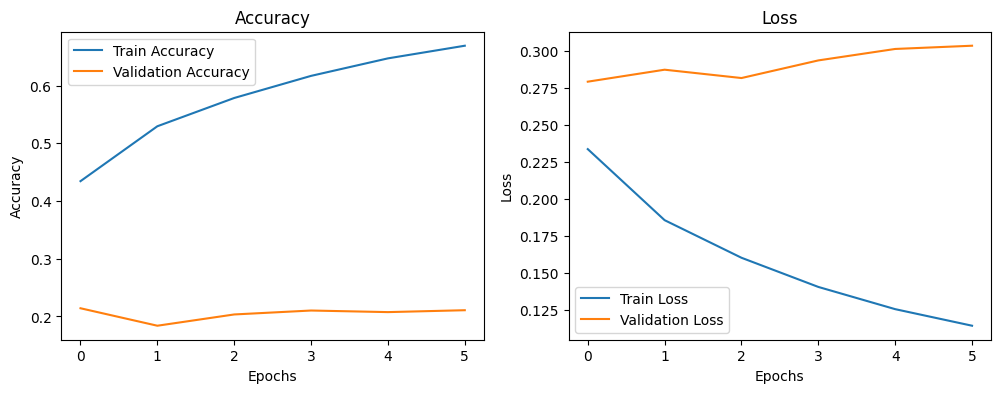

239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.05      0.40      0.09       183
          기타       0.13      0.13      0.13       811
    농,어,임,광업       0.04      0.31      0.07        35
        도소매업       0.07      0.29      0.11       325
     연구개발서비스       0.10      0.55      0.17       300
     정보처리S/W       0.36      0.20      0.26      1682
         제조업       0.76      0.20      0.31      4297

    accuracy                           0.21      7633
   macro avg       0.22      0.30      0.16      7633
weighted avg       0.53      0.21      0.26      7633


Confusion Matrix:
[[  74   27    3   24   13   14   28]
 [ 146  107   28  182  145  130   73]
 [   2    1   11    5    8    1    7]
 [  39   42   17   93   60   51   23]
 [  19   22   10   30  164   32   23]
 [ 157  208   42  460  355  340  120]
 [1061  389  174  606  850  371  846]]


In [84]:
loss, accuracy = model_focal.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_focal.history['accuracy'], label='Train Accuracy')
plt.plot(history_focal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_focal.history['loss'], label='Train Loss')
plt.plot(history_focal.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_focal.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional # Bidirectional 임포트
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 하이퍼파라미터 설정
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

# 모델 정의: Stacked Bidirectional SimpleRNN
model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()

# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          loss='categorical_crossentropy', # 또는 focal loss
                          # loss=categorical_focal_loss(gamma=2.0, alpha=[1.0]*num_classes), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-12 17:20:18.455019: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1880/1880 - 12s - 6ms/step - accuracy: 0.4380 - loss: 1.4017 - val_accuracy: 0.2094 - val_loss: 1.7610
Epoch 2/50
1880/1880 - 10s - 5ms/step - accuracy: 0.5529 - loss: 1.1512 - val_accuracy: 0.2380 - val_loss: 1.7670
Epoch 3/50
1880/1880 - 10s - 5ms/step - accuracy: 0.5951 - loss: 1.0579 - val_accuracy: 0.2454 - val_loss: 1.8140
Epoch 4/50
1880/1880 - 10s - 5ms/step - accuracy: 0.6165 - loss: 1.0063 - val_accuracy: 0.2677 - val_loss: 1.7854
Epoch 5/50
1880/1880 - 10s - 5ms/step - accuracy: 0.6338 - loss: 0.9677 - val_accuracy: 0.2645 - val_loss: 1.8222
Epoch 6/50
1880/1880 - 10s - 5ms/step - accuracy: 0.6479 - loss: 0.9359 - val_accuracy: 0.2899 - val_loss: 1.8067
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
--- 모델 학습 종료 ---



2025-05-12 17:21:07.080960: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 1.7610
Test Accuracy: 0.2094


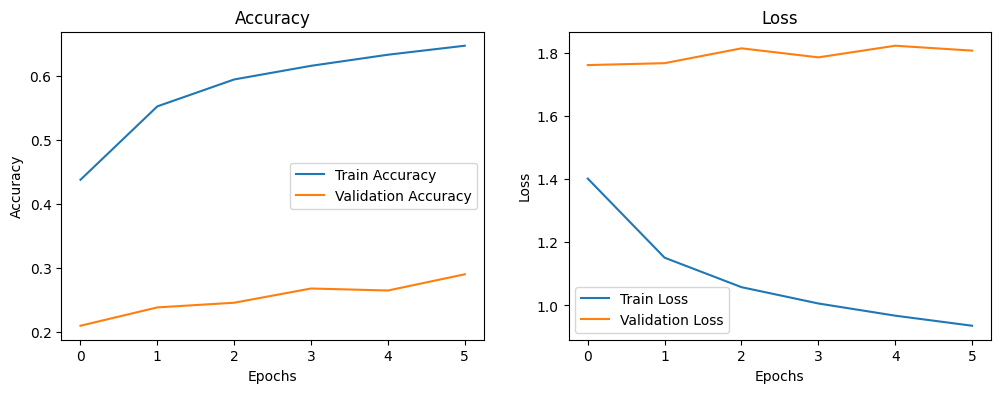

239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.05      0.49      0.09       183
          기타       0.19      0.14      0.16       811
    농,어,임,광업       0.03      0.29      0.06        35
        도소매업       0.06      0.27      0.10       325
     연구개발서비스       0.12      0.48      0.19       300
     정보처리S/W       0.36      0.35      0.35      1682
         제조업       0.75      0.13      0.23      4297

    accuracy                           0.21      7633
   macro avg       0.22      0.31      0.17      7633
weighted avg       0.53      0.21      0.24      7633


Confusion Matrix:
[[  90   15    7   21   13   23   14]
 [ 152  115   14  147  113  213   57]
 [   3    1   10    6    8    3    4]
 [  40   17   21   87   48   89   23]
 [  23   21   14   37  143   48   14]
 [ 178  167   47  359  273  582   76]
 [1285  271  177  704  641  648  571]]


In [86]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

In [220]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 음절(문자) 단위 전처리를 수행하는 예측 함수
def predict_company_char_rnn(name_str, tokenizer, max_len, model_to_predict, label_encoder_obj):
    
    # 1. 입력된 업체명을 음절(문자) 단위로 분리하고 공백으로 연결
    #    (char_tokenizer가 이 형태의 데이터로 fit되었다고 가정)
    processed_name = ' '.join(list(name_str))

    # 2. Tokenizer를 사용하여 정수 시퀀스로 변환
    sequence = tokenizer.texts_to_sequences([processed_name])

    # 3. 패딩 적용 (학습 시와 동일한 max_len, padding, truncating 사용)
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 4. 모델 예측 수행
    prediction_probs = model_to_predict.predict(padded_sequence)

    # 5. 가장 높은 확률을 가진 클래스 인덱스 찾기
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # 6. 예측된 클래스 인덱스를 실제 라벨명으로 변환
    predicted_class_label = label_encoder_obj.inverse_transform([predicted_class_index])[0]

    # 7. 해당 예측의 신뢰도(확률) 추출
    confidence_score = prediction_probs[0][predicted_class_index]

    return predicted_class_label, confidence_score

try:
    new_company_name = "네오노비스"
    # 올바른 객체 전달: char_tokenizer, char_max_len, 학습된 모델, label_encoder
    predicted_label, confidence = predict_company_char_rnn(
        new_company_name,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"\n업체명 '{new_company_name}'의 예측 업종: {predicted_label} (신뢰도: {confidence:.2f})")

    new_company_name_2 = "나우네버"
    predicted_label_2, confidence_2 = predict_company_char_rnn(
        new_company_name_2,
        char_tokenizer,     # <--- 음절 단위 토크나이저
        char_max_len,       # <--- 음절 단위 최대 길이
        model_stacked_rnn,  # <--- 음절 단위로 학습된 모델
        label_encoder
    )
    print(f"업체명 '{new_company_name_2}'의 예측 업종: {predicted_label_2} (신뢰도: {confidence_2:.2f})")

except NameError as e:
    print(f"\n오류: 예측 함수 실행에 필요한 객체({e})가 정의되지 않았습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

업체명 '네오노비스'의 예측 업종: 연구개발서비스 (신뢰도: 0.31)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
업체명 '나우네버'의 예측 업종: 제조업 (신뢰도: 0.30)


------

-------

-----

## 다음 단계 업체명 + 주생산품

RNN과 업체명만으로는 카테고리를 분류하기 어려움이 있음(데이터 불균형 및 정보 부족)
-> 추가 정보를 제공하자.

### Simple RNN

In [143]:
# 필요한 컬럼 선택 및 결측치 처리 (업체명, 주생산품, 업종분류(기보))
required_cols = ['업체명', '주생산품', '업종분류(기보)']
df_selected = df[required_cols].copy()
df_selected.dropna(subset=required_cols, inplace=True)
print(f"\nAfter dropping NA in required columns: {len(df_selected)}")

# "(주)", "주식회사", "㈜" 등 제거 (이전 단계에서 정의한 패턴 사용)
patterns_to_remove = [
    r'\(\s*주\s*\)', r'\(주\)', r'주식회사\s*', r'\s*주식회사', '㈜',
    r'\(\s*유\s*\)', r'\(유\)', r'유한회사\s*', r'\s*유한회사',
    # 필요시 다른 법인 형태 추가
]
combined_pattern = '|'.join(patterns_to_remove)
df_selected['업체명'] = df_selected['업체명'].str.replace(combined_pattern, '', regex=True).str.strip()
# 주생산품 컬럼도 유사한 전처리가 필요할 수 있으나, 여기서는 일단 생략

def remove_special_characters(text):
    # NaN 값이나 빈 문자열일 경우 그대로 반환
    if pd.isna(text) or text == '':
        return ''
    # 한글, 영어, 숫자, 공백을 제외한 모든 문자 제거
    # 필요에 따라 유지하고 싶은 다른 특수문자가 있다면 정규식에 추가 (예: '.', '-', '&' 등)
    # 여기서는 기본적인 특수문자만 제거합니다.
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', ' ', str(text))
    text = re.sub(r'\s+', ' ', text).strip() # 다중 공백을 단일 공백으로 변경하고 양쪽 공백 제거
    return text

# --- 업체명 및 주생산품에 특수문자 제거 적용 ---
df_selected['업체명'] = df_selected['업체명'].apply(remove_special_characters)
df_selected['주생산품'] = df_selected['주생산품'].apply(remove_special_characters)

print("\nAfter removing special characters (sample):")
print(df_selected[['업체명', '주생산품']].head())

# 타겟 카테고리 필터링 (7개 클래스)
target_categories = ['기타', '제조업', '정보처리S/W', '농,어,임,광업', '건설운수', '연구개발서비스', '도소매업']
df_filtered = df_selected[df_selected['업종분류(기보)'].isin(target_categories)].copy()
print(f"After filtering for target categories: {len(df_filtered)}")
print("\nFiltered Class Distribution:")
print(df_filtered['업종분류(기보)'].value_counts())

# --- 3. 입력 텍스트 결합 ---
# 업체명과 주생산품을 구분자 '[SEP]'와 함께 결합
# 주생산품이 비어있거나 NaN인 경우를 대비하여 fillna('') 추가
df_filtered['combined_input'] = df_filtered['업체명'].fillna('') + ' [SEP] ' + df_filtered['주생산품'].fillna('')
print("\nSample of combined input:")
print(df_filtered[['업체명', '주생산품', 'combined_input']].head())

# --- 4. 라벨 인코딩 및 데이터 분할 ---
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
df_filtered['업종분류_encoded'] = label_encoder.fit_transform(df_filtered['업종분류(기보)'])
num_classes = len(label_encoder.classes_)
print(f"\nNumber of classes: {num_classes}")
print("Class to index mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

X = df_filtered['combined_input']
y = df_filtered['업종분류_encoded']

# 데이터 분할 (stratify 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# 라벨 원-핫 인코딩
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print(f"\nTrain data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")
print(f"Train label distribution:\n{y_train.value_counts().sort_index()}")


# --- 5. 음절(문자) 단위 토큰화 및 패딩 ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 음절 단위 분리 및 공백 추가 ("삼성전자 [SEP] 반도체" -> "ㅅ ㅏ ㅁ ㅅ ㅓ ㅇ ㅈ ㅓ ㄴ ㅈ ㅏ   [ S E P ]   ㅂ ㅏ ㄴ ㄷ ㅗ ㅊ ㅔ")
X_train_chars = [' '.join(list(str(text))) for text in X_train]
X_test_chars = [' '.join(list(str(text))) for text in X_test]

# 2. Tokenizer 생성 및 학습 데이터에 fit
# vocab_size를 너무 작게 잡으면 성능 저하 가능성 있음. 고유 문자 수 확인 후 설정 권장.
char_tokenizer = Tokenizer(oov_token="<OOV>")
char_tokenizer.fit_on_texts(X_train_chars)
actual_char_vocab_size = len(char_tokenizer.word_index) + 1
print(f"\nActual character vocabulary size: {actual_char_vocab_size}")

# 3. 시퀀스 변환
X_train_sequences_char = char_tokenizer.texts_to_sequences(X_train_chars)
X_test_sequences_char = char_tokenizer.texts_to_sequences(X_test_chars)

# 4. 시퀀스 길이 분석 및 maxlen 결정 (결합된 텍스트 기준)
sequence_lengths = [len(seq) for seq in X_train_sequences_char]
lengths_series = pd.Series(sequence_lengths)
print("\nSequence Length Stats (Combined Text):")
print(lengths_series.describe())

# 예: 95% 지점 또는 다른 기준으로 maxlen 설정 
char_max_len = int(np.percentile(sequence_lengths, 95))
# char_max_len = 150 # 예시 값, 실제 분포를 보고 조정 필요
print(f"Selected max length (char_max_len): {char_max_len}")

# 5. 패딩
X_train_padded_char = pad_sequences(X_train_sequences_char, maxlen=char_max_len, padding='post', truncating='post')
X_test_padded_char = pad_sequences(X_test_sequences_char, maxlen=char_max_len, padding='post', truncating='post')
print(f"Padded training sequences shape: {X_train_padded_char.shape}")
print(f"Padded testing sequences shape: {X_test_padded_char.shape}")



After dropping NA in required columns: 37926

After removing special characters (sample):
      업체명                  주생산품
0  브랜드하우스                   콘텐츠
1      피노      간판 옥외광고물 실사출력 제품
2    두진테크               금속구조물창호
3   트렌드잇플  빅데이터 기반 인플루언서 매칭 플랫폼
4     인퍼니     작업용의자 사무용의자 게이밍의자
After filtering for target categories: 37926

Filtered Class Distribution:
업종분류(기보)
제조업         21408
정보처리S/W      8363
기타           4012
도소매업         1623
연구개발서비스      1439
건설운수          913
농,어,임,광업      168
Name: count, dtype: int64

Sample of combined input:
      업체명                  주생산품                    combined_input
0  브랜드하우스                   콘텐츠                  브랜드하우스 [SEP] 콘텐츠
1      피노      간판 옥외광고물 실사출력 제품         피노 [SEP] 간판 옥외광고물 실사출력 제품
2    두진테크               금속구조물창호                두진테크 [SEP] 금속구조물창호
3   트렌드잇플  빅데이터 기반 인플루언서 매칭 플랫폼  트렌드잇플 [SEP] 빅데이터 기반 인플루언서 매칭 플랫폼
4     인퍼니     작업용의자 사무용의자 게이밍의자       인퍼니 [SEP] 작업용의자 사무용의자 게이밍의자

Number of classes: 7
Class to index mapping:
건설운수: 0
기타: 

In [110]:
# --- 6. 기본 SimpleRNN 모델 정의 ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

embedding_dim = 64  # 임베딩 차원
hidden_units = 64   # RNN 유닛 수

model_base_combined = Sequential([
    Embedding(input_dim=actual_char_vocab_size,
              output_dim=embedding_dim,
              input_length=char_max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])

model_base_combined.summary()

# --- 7. 모델 컴파일 ---
# (클래스 불균형 처리는 이 실험에서는 적용 안 함)
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model_base_combined.compile(optimizer=optimizer,
                            loss='categorical_crossentropy', # 표준 손실 함수
                            metrics=['accuracy'])

# --- 8. 모델 학습 (EarlyStopping 사용) ---
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

print("\n--- Combined Text Input, Basic SimpleRNN 모델 학습 시작 ---")
history_base_combined = model_base_combined.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    verbose=2
)
print("--- 모델 학습 종료 ---\n")


/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Combined Text Input, Basic SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-13 11:11:47.407094: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


475/475 - 3s - 6ms/step - accuracy: 0.6448 - loss: 1.1716 - val_accuracy: 0.7208 - val_loss: 0.9431
Epoch 2/50
475/475 - 2s - 4ms/step - accuracy: 0.7221 - loss: 0.9508 - val_accuracy: 0.7208 - val_loss: 0.9175
Epoch 3/50
475/475 - 2s - 4ms/step - accuracy: 0.7278 - loss: 0.9006 - val_accuracy: 0.7212 - val_loss: 0.9287
Epoch 4/50
475/475 - 2s - 4ms/step - accuracy: 0.7309 - loss: 0.8815 - val_accuracy: 0.7168 - val_loss: 0.9217
Epoch 5/50
475/475 - 2s - 4ms/step - accuracy: 0.7346 - loss: 0.8647 - val_accuracy: 0.7319 - val_loss: 0.8751
Epoch 6/50
475/475 - 2s - 4ms/step - accuracy: 0.7422 - loss: 0.8386 - val_accuracy: 0.7340 - val_loss: 0.8689
Epoch 7/50
475/475 - 2s - 4ms/step - accuracy: 0.7482 - loss: 0.8164 - val_accuracy: 0.7310 - val_loss: 0.8741
Epoch 8/50
475/475 - 2s - 4ms/step - accuracy: 0.7577 - loss: 0.7981 - val_accuracy: 0.7369 - val_loss: 0.8672
Epoch 9/50
475/475 - 2s - 4ms/step - accuracy: 0.7673 - loss: 0.7714 - val_accuracy: 0.7452 - val_loss: 0.8508
Epoch 10/50


--- 모델 평가 시작 ---


2025-05-13 11:02:07.103866: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Test Loss (Combined Text, Basic SimpleRNN): 0.8508
Test Accuracy (Combined Text, Basic SimpleRNN): 0.7452


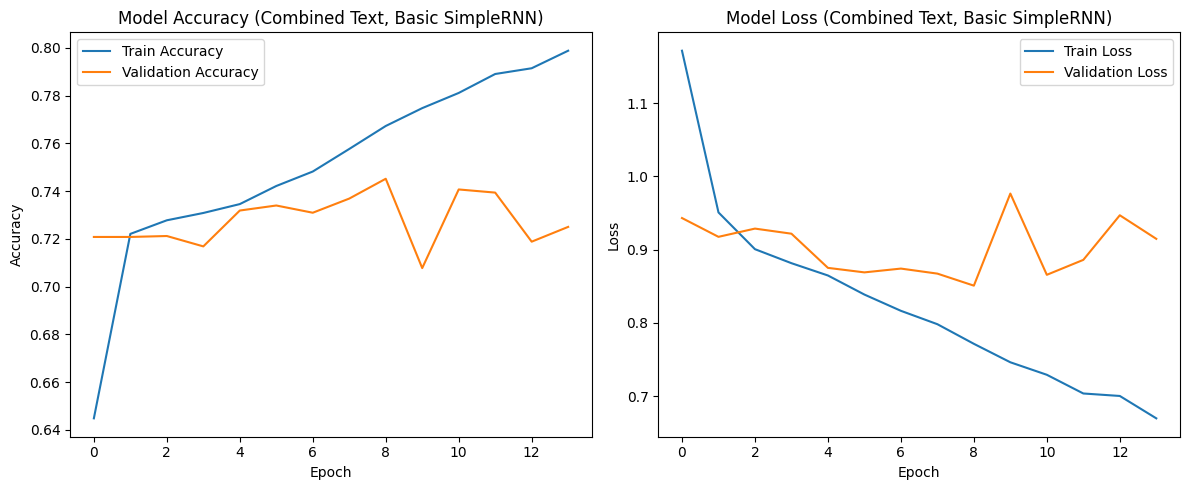

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report (Combined Text, Basic SimpleRNN):
              precision    recall  f1-score   support

        건설운수       0.00      0.00      0.00       183
          기타       0.52      0.35      0.42       802
    농,어,임,광업       0.00      0.00      0.00        33
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.34      0.07      0.11       288
     정보처리S/W       0.70      0.78      0.74      1673
         제조업       0.79      0.94      0.86      4282

    accuracy                           0.75      7586
   macro avg       0.34      0.31      0.30      7586
weighted avg       0.67      0.75      0.70      7586


Confusion Matrix (Combined Text, Basic SimpleRNN):
          건설운수   기타  농,어,임,광업  도소매업  연구개발서비스  정보처리S/W   제조업
건설운수         0   38         0     0        0       15   130
기타           0  283         0     0        9      260   250
농,어,임,광업     0    0         0     0        0        3    30
도소매업         

In [98]:
import matplotlib.pyplot as plt
# --- 9. 모델 평가 ---
print("--- 모델 평가 시작 ---")
loss, accuracy = model_base_combined.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"Test Loss (Combined Text, Basic SimpleRNN): {loss:.4f}")
print(f"Test Accuracy (Combined Text, Basic SimpleRNN): {accuracy:.4f}")

# 학습 과정 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base_combined.history['accuracy'], label='Train Accuracy')
plt.plot(history_base_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Combined Text, Basic SimpleRNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base_combined.history['loss'], label='Train Loss')
plt.plot(history_base_combined.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Combined Text, Basic SimpleRNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Classification Report 및 Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred_probs = model_base_combined.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

try:
    target_names = label_encoder.classes_
    if len(target_names) != num_classes:
        target_names = [f"Class_{i}" for i in range(num_classes)]
except NameError:
    target_names = [f"Class_{i}" for i in range(num_classes)]
except AttributeError:
    target_names = [f"Class_{i}" for i in range(num_classes)]


print("\nClassification Report (Combined Text, Basic SimpleRNN):")
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names, zero_division=0))

print("\nConfusion Matrix (Combined Text, Basic SimpleRNN):")
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test_classes, y_pred_classes), index=target_names, columns=target_names)
print(conf_matrix_df)
print("--- 모델 평가 종료 ---\n")

In [114]:
# 업체명 + 주생산품 결합 입력을 처리하는 예측 함수
def predict_company_combined_rnn(name_str, product_str, tokenizer, max_len, model_to_predict, label_encoder_obj):
    # 1. 업체명과 주생산품 결합 (학습 시 사용한 동일한 구분자 사용)
    #    입력값이 None일 경우 등을 대비해 str() 및 strip() 처리 추가
    name_str_cleaned = str(name_str).strip() if name_str else ""
    product_str_cleaned = str(product_str).strip() if product_str else ""
    combined_text = f"{name_str_cleaned} [SEP] {product_str_cleaned}"

    # 2. 결합된 텍스트를 음절(문자) 단위로 분리하고 공백으로 연결
    processed_text = ' '.join(list(combined_text))

    # 3. Tokenizer를 사용하여 정수 시퀀스로 변환
    sequence = tokenizer.texts_to_sequences([processed_text])

    # 4. 패딩 적용 (학습 시와 동일한 max_len, padding, truncating 사용)
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 5. 모델 예측 수행
    prediction_probs = model_to_predict.predict(padded_sequence)

    # 6. 가장 높은 확률을 가진 클래스 인덱스 찾기
    predicted_class_index = np.argmax(prediction_probs, axis=1)[0]

    # 7. 예측된 클래스 인덱스를 실제 라벨명으로 변환
    predicted_class_label = label_encoder_obj.inverse_transform([predicted_class_index])[0]

    # 8. 해당 예측의 신뢰도(확률) 추출
    confidence_score = prediction_probs[0][predicted_class_index]

    return predicted_class_label, confidence_score

# --- 함수 사용 예시 ---
# 아래 코드 실행 전 char_tokenizer, char_max_len, model_base_combined, label_encoder 변수가 올바르게 정의 및 로드되어 있어야 합니다.

try:
    new_company_name_1 = "두진테크"
    product_info_1 = "금속구조물창호" # 주생산품 정보 추가
    predicted_label_1, confidence_1 = predict_company_combined_rnn(
        new_company_name_1,
        product_info_1,     # <--- 주생산품 정보 전달
        char_tokenizer,     # 음절 단위 토크나이저
        char_max_len,       # 음절 단위 최대 길이
        model_base_combined, # 결합 텍스트로 학습된 모델
        label_encoder
    )
    print(f"\n입력: '{new_company_name_1} [SEP] {product_info_1}'")
    print(f"예측 업종: {predicted_label_1} (신뢰도: {confidence_1:.2f})")

    # 예시 2
    new_company_name_2 = "트렌드잇플"
    product_info_2 = "빅데이터 기반 인플루언서 매칭 플랫폼" # 주생산품 정보 추가
    predicted_label_2, confidence_2 = predict_company_combined_rnn(
        new_company_name_2,
        product_info_2,     # <--- 주생산품 정보 전달
        char_tokenizer,
        char_max_len,
        model_base_combined,
        label_encoder
    )
    print(f"\n입력: '{new_company_name_2} [SEP] {product_info_2}'")
    print(f"예측 업종: {predicted_label_2} (신뢰도: {confidence_2:.2f})")

    #예시 3 : 
    new_company_name_3 = "로코모스튜디오"
    product_info_3 = "VR 애니메이션 영상" # 또는 None
    predicted_label_3, confidence_3 = predict_company_combined_rnn(
        new_company_name_3,
        product_info_3,
        char_tokenizer,
        char_max_len,
        model_base_combined,
        label_encoder
    )
    print(f"\n입력: '{new_company_name_3} [SEP] {product_info_3}'")
    print(f"예측 업종: {predicted_label_3} (신뢰도: {confidence_3:.2f})")


except NameError as e:
    print(f"\n오류: 예측 함수 실행에 필요한 객체({e})가 정의되지 않았습니다.")
    print("이전 단계에서 char_tokenizer, char_max_len, 학습된 모델, label_encoder 객체를 준비해주세요.")
except Exception as e:
     print(f"\n예측 중 오류 발생: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

입력: '두진테크 [SEP] 금속구조물창호'
예측 업종: 제조업 (신뢰도: 0.95)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

입력: '트렌드잇플 [SEP] 빅데이터 기반 인플루언서 매칭 플랫폼'
예측 업종: 정보처리S/W (신뢰도: 0.86)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

입력: '로코모스튜디오 [SEP] VR 애니메이션 영상'
예측 업종: 정보처리S/W (신뢰도: 0.45)


2025-05-13 11:17:33.282229: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


### Simple RNN + focal loss

In [131]:
import tensorflow as tf
import tensorflow.keras.backend as K


def categorical_focal_loss(gamma=2.0, alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon() # 작은 값을 더해 log(0) 방지
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon) # 예측값을 범위 내로 클리핑

        # y_true를 y_pred와 동일한 float 타입으로 변환
        y_true_c = tf.cast(y_true, dtype=y_pred.dtype)

        # 1. p_t 계산: 실제 정답 클래스에 대한 모델의 예측 확률
        # y_true가 원-핫 인코딩 되어 있으므로, 곱한 후 합하면 정답 클래스의 예측 확률만 남음
        p_t = K.sum(y_true_c * y_pred, axis=-1) # 각 샘플에 대한 정답 클래스의 확률, Shape: (batch_size,)

        # 2. 표준 Cross Entropy 계산 (정답 클래스에 대해서만)
        ce = -K.log(p_t + epsilon) # Shape: (batch_size,)

        # 3. Modulating Factor (집중 조절 인자) 계산
        modulating_factor = K.pow(1. - p_t, gamma) # Shape: (batch_size,)
        
        # 4. Focal Loss 계산
        focal_loss_ = modulating_factor * ce # Shape: (batch_size,)

        # 5. Alpha (클래스 가중치 인자) 적용
        if alpha is not None:
            if isinstance(alpha, (list, tuple, np.ndarray)): # alpha가 클래스별 가중치 리스트/배열인 경우
                alpha_weights = K.constant(np.array(alpha, dtype=K.floatx()))
                # 정답 클래스에 해당하는 alpha 가중치 선택
                alpha_factor = K.sum(y_true_c * alpha_weights, axis=-1) # Shape: (batch_size,)
                focal_loss_ = alpha_factor * focal_loss_
            else: # alpha가 스칼라 값인 경우 (모든 클래스에 동일한 가중치 적용)
                focal_loss_ = alpha * focal_loss_
                
        return K.mean(focal_loss_) # 배치 전체에 대한 평균 손실 반환
    return focal_loss_fixed

# --- 7. 클래스 가중치 계산 (Focal Loss의 Alpha로 사용) ---
# y_train (숫자 라벨) 필요
class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# 클래스 인덱스에 맞춰 리스트 생성 (만약 compute_class_weight가 정렬된 클래스 순서로 반환한다면)
# 또는 딕셔너리 생성 후 리스트 변환
class_weight_dict = dict(enumerate(class_weights_list))

cw = {i: w for i, w in class_weight_dict.items()}
total = sum(cw.values())
factor = len(cw) / total
normalized_cw = {i: float(w * factor) for i, w in cw.items()}

sqrt_cw = {i: float(np.sqrt(w)) 
           for i, w in normalized_cw.items()}
alpha_values = [sqrt_cw.get(i, 1.0) for i in range(num_classes)]

# --- 8. 기본 SimpleRNN 모델 정의 (이전과 동일) ---
embedding_dim = 64
hidden_units = 64

model_focal = Sequential([
    Embedding(input_dim=actual_char_vocab_size,
              output_dim=embedding_dim,
              input_length=char_max_len,embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    SimpleRNN(hidden_units, return_sequences=False,kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42), recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED)),
    Dropout(0.5,seed=42),
    Dense(hidden_units // 2, activation='relu',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.3,seed=42),
    Dense(num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.GlorotUniform(seed=42))
])

model_focal.summary()

# 모델 컴파일: Focal Loss 사용
# gamma는 보통 2.0을 많이 사용. alpha는 클래스 가중치 역할을 하며,
# None으로 두면 focal_loss_ 함수 내부에서 alpha 적용 부분이 스킵됩니다.
# 또는 alpha=1.0 (스칼라)로 설정할 수도 있습니다. 여기서는 alpha=None으로 설정하여 gamma의 효과만 보겠습니다.
gamma_value = 2.5 # Focal Loss의 gamma 값 (튜닝 가능)
# alpha_value = None # 클래스 가중치 효과 없이 gamma의 focusing 효과만 보려면
alpha_value = None # 논문에서 자주 사용되는 스칼라 값 (모든 클래스에 동일하게 적용되어 클래스별 가중 효과는 약함)
                   # 또는 alpha_value = [1.0] * num_classes # 모든 클래스에 동일 가중치 1.0

optimizer = Adam(learning_rate=0.001)
model_focal.compile(optimizer=optimizer, 
                    # loss = 'categorical_crossentropy',
                    loss=categorical_focal_loss(gamma=gamma_value, alpha=alpha_values), # <--- 변경점: Focal Loss 적용
                    metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # 예시: 5 에포크 동안 개선 없을 시 중단 (데이터셋과 모델에 따라 3~10 정도로 조절)
    restore_best_weights=True,
    verbose=1
)

epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---")
history_focal = model_focal.fit(
    X_train_padded_char,
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot),
    callbacks=[early_stopping],
    # class_weight는 사용하지 않음
    verbose=2
)

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_32 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, SimpleRNN 모델 (Focal Loss 적용) 학습 시작 ---
Epoch 1/50


2025-05-13 11:50:12.908634: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


475/475 - 3s - 5ms/step - accuracy: 0.5384 - loss: 0.3481 - val_accuracy: 0.6325 - val_loss: 0.3099
Epoch 2/50
475/475 - 2s - 4ms/step - accuracy: 0.6659 - loss: 0.2900 - val_accuracy: 0.6994 - val_loss: 0.2530
Epoch 3/50
475/475 - 2s - 4ms/step - accuracy: 0.6778 - loss: 0.2603 - val_accuracy: 0.6832 - val_loss: 0.2420
Epoch 4/50
475/475 - 2s - 4ms/step - accuracy: 0.6775 - loss: 0.2474 - val_accuracy: 0.6944 - val_loss: 0.2500
Epoch 5/50
475/475 - 2s - 4ms/step - accuracy: 0.6778 - loss: 0.2332 - val_accuracy: 0.6855 - val_loss: 0.2351
Epoch 6/50
475/475 - 2s - 4ms/step - accuracy: 0.6779 - loss: 0.2197 - val_accuracy: 0.6988 - val_loss: 0.2213
Epoch 7/50
475/475 - 2s - 4ms/step - accuracy: 0.6806 - loss: 0.2068 - val_accuracy: 0.6548 - val_loss: 0.2337
Epoch 8/50
475/475 - 2s - 4ms/step - accuracy: 0.6802 - loss: 0.2034 - val_accuracy: 0.7047 - val_loss: 0.2293
Epoch 9/50
475/475 - 2s - 4ms/step - accuracy: 0.6850 - loss: 0.1965 - val_accuracy: 0.6693 - val_loss: 0.2494
Epoch 10/50


2025-05-13 11:50:46.134830: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2213
Test Accuracy: 0.6988


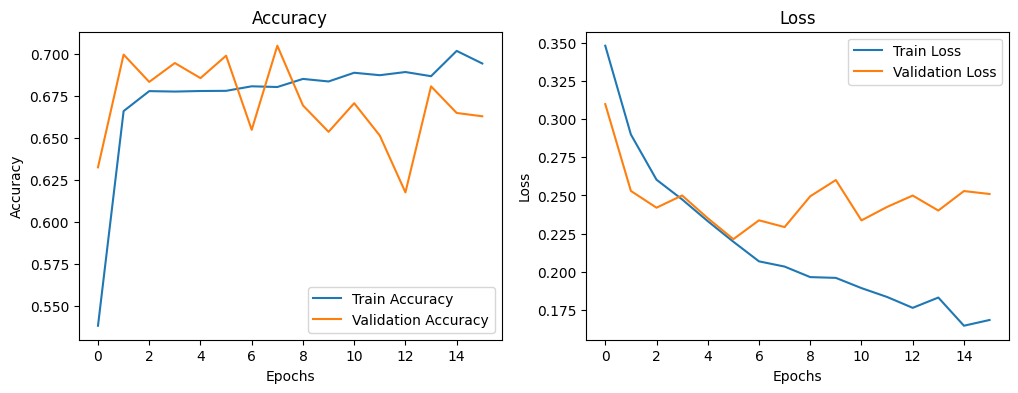

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.21      0.31      0.25       183
          기타       0.39      0.06      0.11       802
    농,어,임,광업       0.17      0.27      0.21        33
        도소매업       0.17      0.01      0.01       325
     연구개발서비스       0.28      0.21      0.24       288
     정보처리S/W       0.61      0.85      0.71      1673
         제조업       0.81      0.86      0.83      4282

    accuracy                           0.70      7586
   macro avg       0.38      0.37      0.34      7586
weighted avg       0.66      0.70      0.66      7586


Confusion Matrix:
[[  56    8    0    0    0   17  102]
 [  46   52    2    1   18  452  231]
 [   3    0    9    1    1    2   17]
 [   5    2    5    2   15   57  239]
 [   5    4    0    2   60   89  128]
 [   9   33    1    1   31 1425  173]
 [ 148   34   35    5   87  276 3697]]


In [132]:
loss, accuracy = model_focal.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_focal.history['accuracy'], label='Train Accuracy')
plt.plot(history_focal.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_focal.history['loss'], label='Train Loss')
plt.plot(history_focal.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_focal.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### Bidirectional RNN 

In [136]:
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

# 모델 정의: Stacked Bidirectional SimpleRNN
model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()


class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# 클래스 인덱스에 맞춰 리스트 생성 (만약 compute_class_weight가 정렬된 클래스 순서로 반환한다면)
# 또는 딕셔너리 생성 후 리스트 변환
class_weight_dict = dict(enumerate(class_weights_list))

cw = {i: w for i, w in class_weight_dict.items()}
total = sum(cw.values())
factor = len(cw) / total
normalized_cw = {i: float(w * factor) for i, w in cw.items()}

sqrt_cw = {i: float(np.sqrt(w)) 
           for i, w in normalized_cw.items()}
alpha_values = [sqrt_cw.get(i, 1.0) for i in range(num_classes)]


# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          loss='categorical_crossentropy', # 표준 손실 함수
                          # loss=categorical_focal_loss(gamma=2.0, alpha=alpha_values), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-13 14:13:25.518030: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-13 14:13:31.706980: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

475/475 - 7s - 14ms/step - accuracy: 0.6486 - loss: 1.1422 - val_accuracy: 0.7393 - val_loss: 0.8618
Epoch 2/50
475/475 - 5s - 10ms/step - accuracy: 0.7429 - loss: 0.8954 - val_accuracy: 0.7551 - val_loss: 0.8147
Epoch 3/50
475/475 - 5s - 10ms/step - accuracy: 0.7605 - loss: 0.8313 - val_accuracy: 0.7596 - val_loss: 0.7869
Epoch 4/50
475/475 - 5s - 11ms/step - accuracy: 0.7658 - loss: 0.8007 - val_accuracy: 0.7571 - val_loss: 0.8020
Epoch 5/50
475/475 - 5s - 11ms/step - accuracy: 0.7709 - loss: 0.7821 - val_accuracy: 0.7614 - val_loss: 0.7855
Epoch 6/50
475/475 - 5s - 11ms/step - accuracy: 0.7774 - loss: 0.7526 - val_accuracy: 0.7631 - val_loss: 0.7805
Epoch 7/50
475/475 - 5s - 11ms/step - accuracy: 0.7823 - loss: 0.7414 - val_accuracy: 0.7598 - val_loss: 0.7946
Epoch 8/50
475/475 - 5s - 11ms/step - accuracy: 0.7865 - loss: 0.7154 - val_accuracy: 0.7582 - val_loss: 0.7900
Epoch 9/50
475/475 - 5s - 11ms/step - accuracy: 0.7879 - loss: 0.7023 - val_accuracy: 0.7677 - val_loss: 0.7696
Epo

2025-05-13 14:15:08.125385: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.7696
Test Accuracy: 0.7677


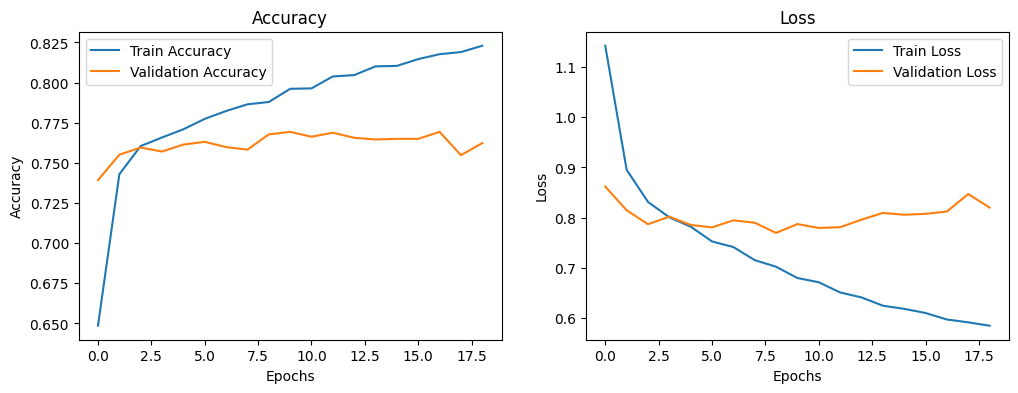

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.39      0.14      0.20       183
          기타       0.62      0.48      0.54       802
    농,어,임,광업       0.00      0.00      0.00        33
        도소매업       0.00      0.00      0.00       325
     연구개발서비스       0.56      0.20      0.29       288
     정보처리S/W       0.75      0.80      0.78      1673
         제조업       0.80      0.94      0.86      4282

    accuracy                           0.77      7586
   macro avg       0.45      0.36      0.38      7586
weighted avg       0.71      0.77      0.73      7586


Confusion Matrix:
[[  25   39    0    0    0   11  108]
 [  15  384    0    0   17  154  232]
 [   0    2    0    0    1    1   29]
 [   2   15    0    0    4   62  242]
 [   1   42    0    0   57   41  147]
 [   1   82    0    0    3 1345  242]
 [  20   58    0    0   20  171 4013]]


In [137]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### Bidirectional RNN + Focal Loss

In [138]:
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

# 모델 정의: Stacked Bidirectional SimpleRNN
model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()


class_weights_list = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# 클래스 인덱스에 맞춰 리스트 생성 (만약 compute_class_weight가 정렬된 클래스 순서로 반환한다면)
# 또는 딕셔너리 생성 후 리스트 변환
class_weight_dict = dict(enumerate(class_weights_list))

cw = {i: w for i, w in class_weight_dict.items()}
total = sum(cw.values())
factor = len(cw) / total
normalized_cw = {i: float(w * factor) for i, w in cw.items()}

sqrt_cw = {i: float(np.sqrt(w)) 
           for i, w in normalized_cw.items()}
alpha_values = [sqrt_cw.get(i, 1.0) for i in range(num_classes)]


# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          # loss='categorical_crossentropy', # 표준 손실 함수
                          loss=categorical_focal_loss(gamma=2.0, alpha=alpha_values), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-13 14:21:47.285944: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-13 14:21:53.397143: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

475/475 - 7s - 16ms/step - accuracy: 0.4783 - loss: 0.3886 - val_accuracy: 0.5798 - val_loss: 0.3354
Epoch 2/50
475/475 - 5s - 10ms/step - accuracy: 0.6315 - loss: 0.3034 - val_accuracy: 0.7147 - val_loss: 0.2505
Epoch 3/50
475/475 - 5s - 10ms/step - accuracy: 0.6923 - loss: 0.2532 - val_accuracy: 0.7368 - val_loss: 0.2288
Epoch 4/50
475/475 - 5s - 11ms/step - accuracy: 0.7106 - loss: 0.2332 - val_accuracy: 0.6826 - val_loss: 0.2288
Epoch 5/50
475/475 - 5s - 11ms/step - accuracy: 0.7155 - loss: 0.2201 - val_accuracy: 0.7270 - val_loss: 0.2222
Epoch 6/50
475/475 - 5s - 11ms/step - accuracy: 0.7155 - loss: 0.2080 - val_accuracy: 0.7064 - val_loss: 0.2224
Epoch 7/50
475/475 - 5s - 11ms/step - accuracy: 0.7198 - loss: 0.2009 - val_accuracy: 0.7176 - val_loss: 0.2228
Epoch 8/50
475/475 - 5s - 11ms/step - accuracy: 0.7166 - loss: 0.1917 - val_accuracy: 0.6886 - val_loss: 0.2281
Epoch 9/50
475/475 - 5s - 11ms/step - accuracy: 0.7221 - loss: 0.1868 - val_accuracy: 0.6988 - val_loss: 0.2340
Epo

2025-05-13 14:23:40.838241: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2222
Test Accuracy: 0.7270


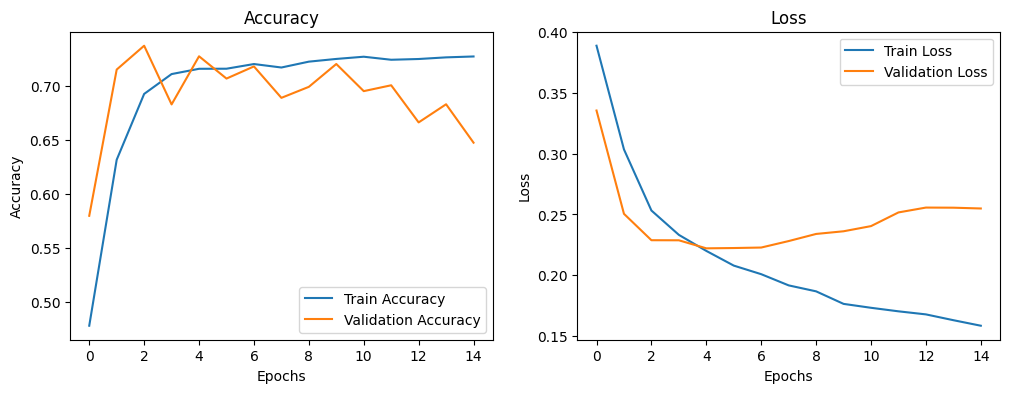

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.25      0.43      0.32       183
          기타       0.50      0.46      0.48       802
    농,어,임,광업       0.13      0.48      0.21        33
        도소매업       0.19      0.03      0.05       325
     연구개발서비스       0.50      0.31      0.38       288
     정보처리S/W       0.73      0.75      0.74      1673
         제조업       0.83      0.86      0.85      4282

    accuracy                           0.73      7586
   macro avg       0.45      0.48      0.43      7586
weighted avg       0.71      0.73      0.72      7586


Confusion Matrix:
[[  79   18    4    0    0    8   74]
 [  95  365    6    4   25  132  175]
 [   0    1   16    0    2    1   13]
 [   1   16    8   10    5   51  234]
 [  10   33    2    0   89   32  122]
 [   7  239    4   16   10 1254  143]
 [ 121   61   80   23   47  248 3702]]


In [140]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

### 소수 클래스 오버샘플링

In [152]:
from imblearn.over_sampling import RandomOverSampler # 또는 SMOTE (텍스트에는 RandomOverSampler가 간단)

ros = RandomOverSampler(random_state=SEED) # SEED는 시드 고정값
try:
    # X_train을 NumPy 배열로 변환 후 reshape
    X_train_reshaped = X_train.values.reshape(-1, 1)
    X_train_resampled_np, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)

    # 결과 확인: 오버샘플링 후 클래스 분포 출력
    print(f"오버샘플링 후 학습 데이터 수: {len(X_train_resampled_np)}")
    print(f"오버샘플링 후 학습 데이터 클래스 분포:\n{pd.Series(y_train_resampled).value_counts().sort_index()}")

    # 3. 오버샘플링된 X 데이터를 다시 1D 형태로 변환 (Tokenizer 입력 준비)
    #    pandas Series로 변환하거나 NumPy 배열의 flatten() 사용 가능
    X_train_resampled = pd.Series(X_train_resampled_np.ravel())
    print("--- RandomOverSampler 적용 완료 ---")

except Exception as e:
    print(f"RandomOverSampler 적용 중 오류 발생: {e}")
    print("오버샘플링 없이 원본 데이터를 사용합니다.")
    # 오류 발생 시 원본 데이터 사용하도록 변수명 맞춰주기 (선택적)
    X_train_resampled = X_train
    y_train_resampled = y_train
# ---------------------------


오버샘플링 후 학습 데이터 수: 119882
오버샘플링 후 학습 데이터 클래스 분포:
업종분류_encoded
0    17126
1    17126
2    17126
3    17126
4    17126
5    17126
6    17126
Name: count, dtype: int64
--- RandomOverSampler 적용 완료 ---


음절 단위 분리 >> 펜 타 게 이 트   [ S E P ]   통 합 관 제 소 프 트 웨 어   영 상 감 시 장 치
학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): 1234
count    119882.000000
mean         20.725272
std          10.687841
min           6.000000
25%          14.000000
50%          18.000000
75%          23.000000
max         162.000000
dtype: float64


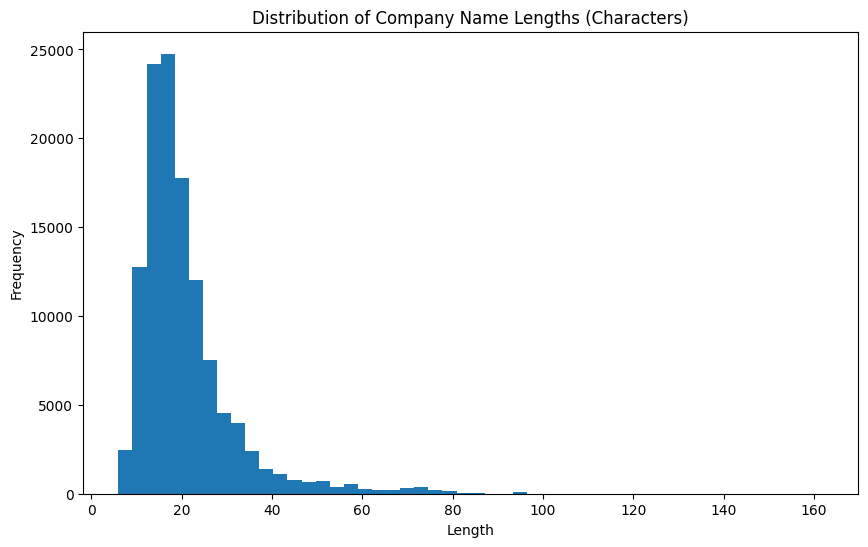

95th percentile length: 41


/home/ternary6/anaconda3/envs/crawl/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---
Epoch 1/50


2025-05-13 15:24:05.825195: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-13 15:24:17.325636: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1874/1874 - 12s - 6ms/step - accuracy: 0.6090 - loss: 1.0709 - val_accuracy: 0.5986 - val_loss: 1.1409
Epoch 2/50
1874/1874 - 10s - 5ms/step - accuracy: 0.7523 - loss: 0.7227 - val_accuracy: 0.5858 - val_loss: 1.2251
Epoch 3/50
1874/1874 - 10s - 5ms/step - accuracy: 0.7955 - loss: 0.6050 - val_accuracy: 0.6258 - val_loss: 1.1988
Epoch 4/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8223 - loss: 0.5352 - val_accuracy: 0.6136 - val_loss: 1.2949
Epoch 5/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8377 - loss: 0.4891 - val_accuracy: 0.5894 - val_loss: 1.3958
Epoch 6/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8499 - loss: 0.4556 - val_accuracy: 0.6035 - val_loss: 1.3693
Epoch 7/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8615 - loss: 0.4247 - val_accuracy: 0.6169 - val_loss: 1.3756
Epoch 8/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8693 - loss: 0.4032 - val_accuracy: 0.6250 - val_loss: 1.4124
Epoch 9/50
1874/1874 - 10s - 5ms/step - accuracy: 0.8786 - loss: 0.3755 - val_accuracy: 0.6432 - va

In [154]:


y_train_one_hot = to_categorical(y_train_resampled, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

X_train_chars = [' '.join(list(name)) for name in X_train_resampled]
X_test_chars = [' '.join(list(name)) for name in X_test]

# 음절 단위 분리
print(f'음절 단위 분리 >> {X_train_chars[0]}')

# 2. Tokenizer 생성 및 학습 데이터에 맞게 단어 사전(문자 사전) 구축
# 여기서 num_words를 설정하지 않거나, 충분히 큰 값으로 설정하면 모든 고유 문자를 포함하게 됩니다.
# oov_token을 설정해주는 것이 좋습니다.
char_tokenizer = Tokenizer(oov_token="<OOV>") # char_level=False가 기본값이며, 공백으로 분리된 토큰을 학습합니다.
char_tokenizer.fit_on_texts(X_train_chars)

# 3. 실제 학습된 고유 문자의 수 확인
# char_tokenizer.word_index에는 학습된 각 문자(토큰)와 해당 정수 인덱스가 저장됩니다.
# <OOV> 토큰도 여기에 포함됩니다.
# 인덱스 0은 Keras에서 보통 패딩을 위해 사용되므로, Embedding 레이어의 input_dim은 보통 len(word_index) + 1이 됩니다.
actual_char_vocab_size = len(char_tokenizer.word_index) + 1
print(f"학습 데이터에서 발견된 고유 음절/문자 수 (패딩 포함 시 input_dim): {actual_char_vocab_size}")

# 4. 이 값을 Embedding 레이어의 input_dim으로 사용합니다.
# Tokenizer의 num_words 파라미터는 texts_to_sequences 시 고려할 단어 수 제한이므로,
# 모든 문자를 사용하려면 설정하지 않거나 위에서 계산된 actual_char_vocab_size보다 크거나 같게 설정할 수 있습니다.
# 명시적으로 Tokenizer에 num_words를 전달하고 싶다면:
# char_tokenizer = Tokenizer(num_words=actual_char_vocab_size, oov_token="<OOV>")
# char_tokenizer.fit_on_texts(X_train_chars) # 다시 fit할 필요는 없지만, 일관성을 위해 num_words를 미리 정하고 fit할 수도 있습니다.

# 5. 시퀀스 변환 및 패딩
X_train_sequences_char = char_tokenizer.texts_to_sequences(X_train_chars)
X_test_sequences_char = char_tokenizer.texts_to_sequences(X_test_chars)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sequence_lengths = [len(seq) for seq in X_train_sequences_char]

lengths_series = pd.Series(sequence_lengths)
print(lengths_series.describe()) # 통계치 확인 (평균, 표준편차, 최소, 최대, 사분위수 등)

plt.figure(figsize=(10, 6))
plt.hist(lengths_series, bins=50)
plt.title('Distribution of Company Name Lengths (Characters)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# 예: 95% 지점의 길이로 max_len 설정
# 최대 길이(Max Length): 가장 긴 업체명의 길이를 max_len으로 설정할 경우 정보 손실은 없지만, 
# 대부분의 업체명이 이보다 훨씬 짧다면 불필요한 패딩이 많아져 비효율적일 수 있고, 극단적으로 긴 업체명 하나 때문에 max_len이 너무 커질 수도 있습니다.
chosen_max_len = int(np.percentile(sequence_lengths, 95))
print(f"95th percentile length: {chosen_max_len}")

X_train_padded_char = pad_sequences(X_train_sequences_char, maxlen=char_max_len, padding='post', truncating='post')
X_test_padded_char = pad_sequences(X_test_sequences_char, maxlen=char_max_len, padding='post', truncating='post')

# 6. 모델의 Embedding 레이어 설정
# model.add(Embedding(input_dim=actual_char_vocab_size, output_dim=embedding_dim, input_length=char_max_len))

# 하이퍼파라미터 설정
embedding_dim = 64  # 이전과 동일하게 유지 또는 변경 가능
rnn_units_1 = 64    # 첫 번째 RNN 층 유닛 수
rnn_units_2 = 32    # 두 번째 RNN 층 유닛 수 (첫 층보다 작거나 같게 설정 가능)

# 모델 정의: Stacked Bidirectional SimpleRNN
model_stacked_rnn = Sequential([
    Embedding(input_dim=actual_char_vocab_size, 
              output_dim=embedding_dim,
              input_length=char_max_len, 
              embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),

    # 첫 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_1,
                            return_sequences=True,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가 (비율 조정 가능)

    # 두 번째 Bidirectional SimpleRNN 층
    Bidirectional(SimpleRNN(rnn_units_2,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
                            recurrent_initializer=tf.keras.initializers.Orthogonal(seed=SEED))),
    Dropout(0.4, seed=SEED), # Dropout 추가

    # Dense 층
    Dense(hidden_units // 2, # hidden_units는 이전 정의 값 사용 (예: 64)
          activation='relu',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(num_classes, # 분류할 클래스 수로 변경해야 합니다
          activation='softmax',
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))
])

model_stacked_rnn.summary()

# 모델 컴파일 (이전 실험과 동일한 옵티마이저, 손실 함수 사용)
# 예: Categorical Crossentropy 사용
optimizer = Adam(learning_rate=0.001)
model_stacked_rnn.compile(optimizer=optimizer,
                          loss='categorical_crossentropy', # 표준 손실 함수
                          # loss=categorical_focal_loss(gamma=2.0, alpha=0.25), # 예: Focal loss(alpha 미적용)
                          metrics=['accuracy'])

# EarlyStopping 콜백 (이전과 동일)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습 파라미터 (이전과 동일)
epochs = 50
batch_size = 64

print("\n--- 음절 단위 입력, Stacked Bidirectional SimpleRNN 모델 학습 시작 ---")
# !!! 중요: 입력 데이터 변수명 확인 (X_train_padded_char 사용) !!!
history_stacked_rnn = model_stacked_rnn.fit(
    X_train_padded_char, # <--- 사용자 코드의 X_train_padded 대신 음절 단위 데이터 사용
    y_train_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_padded_char, y_test_one_hot), # <--- 사용자 코드의 X_test_padded 대신 음절 단위 데이터 사용
    callbacks=[early_stopping],
    # class_weight=... # 필요 시 클래스 가중치 추가 가능
    verbose=2
)
print("--- 모델 학습 종료 ---\n")

2025-05-13 15:33:46.581975: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 1.6638
Test Accuracy: 0.7005


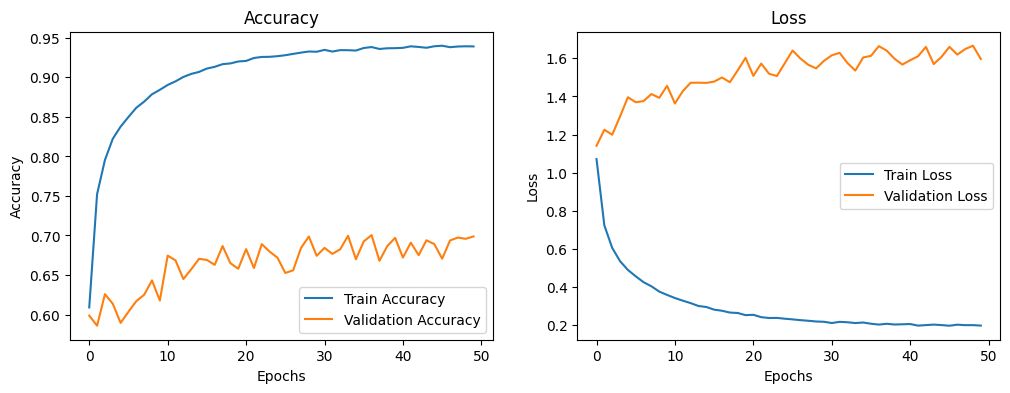

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        건설운수       0.34      0.45      0.39       183
          기타       0.48      0.47      0.47       802
    농,어,임,광업       0.06      0.06      0.06        33
        도소매업       0.21      0.18      0.19       325
     연구개발서비스       0.34      0.44      0.38       288
     정보처리S/W       0.69      0.76      0.72      1673
         제조업       0.84      0.79      0.82      4282

    accuracy                           0.70      7586
   macro avg       0.42      0.45      0.43      7586
weighted avg       0.71      0.70      0.70      7586


Confusion Matrix:
[[  83   15    0    4    2   16   63]
 [  38  376    1   30   50  159  148]
 [   1    1    2    0    1    2   26]
 [   7   37    3   58   17   51  152]
 [   3   34    2    7  126   42   74]
 [  13  135    2   51   30 1274  168]
 [ 102  192   25  120  142  306 3395]]


In [155]:
loss, accuracy = model_stacked_rnn.evaluate(X_test_padded_char, y_test_one_hot, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stacked_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_stacked_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stacked_rnn.history['loss'], label='Train Loss')
plt.plot(history_stacked_rnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 추가 평가 지표
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model_stacked_rnn.predict(X_test_padded_char)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=0)) # zero_division 추가

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

## 정리
1. 주 생산품이라는 정보를 추가로 전달해주는 것이 카테고리 분류에 도움이 됨을 확인. 실제 기업 소개글 등을 활용하는 방법도 고려.
2. 오버샘플링 후 모델은 비록 전체 정확도는 떨어졌지만, 소수 클래스에 대한 예측 능력이 향상되어 데이터 불균형 문제를 완화하고 모델의 실질적인 활용 가치를 높였다는 점에서 더 유의미한 결과라고 판단. 단순 오버샘플링을 진행해 다수 클래스와 비율을 맞췄으나, 세세하게 조정하는 것도 고려.
3. SMOTE는 데이터를 변형 시키기 때문에 사용하지 않음.

In [79]:
import numpy as np

# --- 1. 활성화 함수 및 도함수 ---
def tanh(x):
    """tanh 활성화 함수"""
    return np.tanh(x)

def dtanh(tanh_x):
    """tanh 함수의 도함수. 입력은 이미 tanh(x)가 적용된 값이어야 함."""
    return 1 - tanh_x**2

# --- 2. 손실 함수 (Mean Squared Error - MSE) ---
def mse_loss(y_true, y_pred):
    D = y_true.shape[1] # 출력 벡터의 차원 수
    if D == 0:
        return 0
    squared_errors_sum = np.sum((y_pred - y_true)**2)
    mse = squared_errors_sum / D
    return 0.5 * mse # 0.5는 선택 사항

# --- 3. SimpleRNN 직접 구현 클래스 ---
class SimpleRNNNumpy:
    def __init__(self, vocab_size, hidden_size, output_size, learning_rate=0.01):
        self.vocab_size = vocab_size  # 입력 차원 (원-핫 벡터 크기)
        self.hidden_size = hidden_size
        self.output_size = output_size # 출력 차원 (예측하려는 원-핫 벡터 크기)
        self.learning_rate = learning_rate

        # 가중치 초기화 (작은 랜덤 값으로)
        # 입력 -> 은닉층 가중치
        self.Wxh = np.random.randn(vocab_size, hidden_size) * 0.01
        # 이전 은닉 상태 -> 현재 은닉 상태 가중치 (이것이 바로 '순환 가중치'입니다!)
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        # 은닉층 -> 출력층 가중치
        self.Why = np.random.randn(hidden_size, output_size) * 0.01
        
        # 편향 초기화 (0으로)
        self.bh = np.zeros((1, hidden_size))  # 은닉층 편향
        self.by = np.zeros((1, output_size))  # 출력층 편향

        # 역전파 시 중간 계산값 저장을 위한 딕셔너리
        self.cache = {}

    def forward(self, inputs_sequence):
        """
        순전파를 수행합니다.
        inputs_sequence: 타임스텝별 입력 벡터의 리스트 (예: [[1,0,0], [0,1,0], ...])
        """
        T = len(inputs_sequence)  # 시퀀스 길이
        
        # 중간값 저장을 위해 초기화
        self.cache['x'] = {}  # 각 타임스텝의 입력
        self.cache['h_linear'] = {} # 은닉층 활성화 전 값 (Wx*x + Wh*h_prev + b)
        self.cache['h'] = {0: np.zeros((1, self.hidden_size))} # 초기 은닉 상태 h_0
        self.cache['y_pred'] = {} # 각 타임스텝의 예측값

        outputs_sequence_pred = [] # 최종 예측값들을 저장할 리스트

        for t in range(T):
            xt = np.array(inputs_sequence[t]).reshape(1, -1) # 현재 타임스텝 입력 (1, vocab_size)
            ht_prev = self.cache['h'][t] # 이전 타임스텝의 은닉 상태

            self.cache['x'][t] = xt

            # 은닉 상태 계산: h_t = tanh(x_t @ Wxh + h_{t-1} @ Whh + b_h)
            ht_linear = np.dot(xt, self.Wxh) + np.dot(ht_prev, self.Whh) + self.bh
            ht = tanh(ht_linear)
            
            self.cache['h_linear'][t] = ht_linear
            self.cache['h'][t+1] = ht # 다음 계산을 위해 저장 (t+1 인덱스 사용 주의)

            # 출력 계산: y_t = h_t @ Why + b_y (여기서는 활성화 함수 없이 선형 출력)
            yt_pred = np.dot(ht, self.Why) + self.by
            self.cache['y_pred'][t] = yt_pred
            outputs_sequence_pred.append(yt_pred)
            
        return outputs_sequence_pred

    def backward(self, inputs_sequence, targets_sequence, outputs_sequence_pred):
        """
        역전파 (BPTT - Backpropagation Through Time)를 수행합니다.
        """
        T = len(inputs_sequence)
        
        # 그래디언트 변수들 초기화 (가중치와 동일한 크기로)
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        
        # 다음 타임스텝으로부터 전달될 은닉 상태의 그래디언트 (초기에는 0)
        dh_next = np.zeros((1, self.hidden_size)) 
        
        total_loss_for_sequence = 0

        # 시퀀스의 마지막부터 처음까지 역방향으로 순회
        for t in reversed(range(T)):
            xt = self.cache['x'][t]
            ht = self.cache['h'][t+1]       # 순전파 시 t+1 인덱스에 저장된 h_t
            ht_prev = self.cache['h'][t] # h_{t-1}
            # ht_linear = self.cache['h_linear'][t] # h_t 계산 시 tanh 이전 값

            yt_pred = self.cache['y_pred'][t]
            yt_true = np.array(targets_sequence[t]).reshape(1, -1)

            # 현재 타임스텝의 손실 계산 (정보용)
            loss_t = mse_loss(yt_true, yt_pred)
            total_loss_for_sequence += loss_t
            
            # --- 출력층의 그래디언트 계산 ---
            # 손실 함수(MSE)의 예측값 yt_pred에 대한 도함수: (yt_pred - yt_true)
            # (mse_loss에서 0.5를 곱했으므로, 미분 시 0.5 * 2 * (y_pred - y_true) = (y_pred - y_true))
            # 평균을 취했으므로, yt_true.shape[0]로 나눠줌 (여기서는 1)
            dy_pred = (yt_pred - yt_true) / yt_true.shape[0]

            # Why와 by에 대한 그래디언트 누적
            dWhy += np.dot(ht.T, dy_pred)
            dby += dy_pred
            
            # --- 은닉층의 그래디언트 계산 (BPTT의 핵심) ---
            # 현재 은닉 상태 ht에 대한 그래디언트
            # 1. 출력층으로부터 오는 그래디언트: dy_pred @ Why.T
            # 2. 다음 타임스텝 t+1의 은닉 상태로부터 오는 그래디언트: dh_next
            dh = np.dot(dy_pred, self.Why.T) + dh_next
            
            # tanh 활성화 함수의 그래디언트 적용
            # d(loss)/d(ht_linear) = d(loss)/d(ht) * d(ht)/d(ht_linear)
            # d(ht)/d(ht_linear)는 dtanh(ht) 즉, (1 - ht**2)
            dh_raw = dh * dtanh(ht) # dtanh는 이미 tanh가 적용된 ht를 인자로 받음
            
            # bh에 대한 그래디언트 누적
            dbh += dh_raw
            
            # Wxh에 대한 그래디언트 누적
            dWxh += np.dot(xt.T, dh_raw)
            
            # Whh (순환 가중치)에 대한 그래디언트 누적! 이것이 핵심입니다.
            dWhh += np.dot(ht_prev.T, dh_raw)
            
            # 다음 반복(t-1)을 위해, 현재 dh_raw가 이전 은닉 상태 ht_prev에 미치는 영향(dh_next_for_prev_step)을 계산
            dh_next = np.dot(dh_raw, self.Whh.T)
            
        # (선택적) 그래디언트 클리핑: 그래디언트 폭주를 막기 위해 사용
        # 여기서는 매우 간단한 형태로 구현하거나, 값의 범위를 보고 생략 가능
        clip_value = 5.0
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -clip_value, clip_value, out=dparam)
            
        return total_loss_for_sequence, dWxh, dWhh, dWhy, dbh, dby

    def update_weights(self, dWxh, dWhh, dWhy, dbh, dby):
        """단순 경사 하강법으로 가중치를 업데이트합니다."""
        self.Wxh -= self.learning_rate * dWxh
        self.Whh -= self.learning_rate * dWhh # 순환 가중치 업데이트!
        self.Why -= self.learning_rate * dWhy
        self.bh  -= self.learning_rate * dbh
        self.by  -= self.learning_rate * dby

# --- 4. 더미 데이터 생성 및 학습 루프 ---

# 하이퍼파라미터
vocab_size = 3    # 입력/출력 단어(심볼)의 종류 수
hidden_size = 4   # 은닉 상태의 크기 (자유롭게 설정)
output_size = vocab_size # 다음 심볼을 예측하므로 vocab_size와 동일
learning_rate = 0.1
epochs = 100

# 더미 시퀀스 데이터: 0 -> 1 -> 2 -> 0 (순환)
# 입력: [0, 1, 2], 타겟: [1, 2, 0] (다음 스텝 예측)
# 원-핫 인코딩으로 표현
# x_0 = [1,0,0], x_1 = [0,1,0], x_2 = [0,0,1]
# y_0_true = [0,1,0], y_1_true = [0,0,1], y_2_true = [1,0,0]

inputs_indices = [0, 1, 2]
targets_indices = [1, 2, 0] 

# 원-핫 인코딩된 시퀀스 생성
inputs_sequence_onehot = [np.eye(vocab_size)[i] for i in inputs_indices]
targets_sequence_onehot = [np.eye(vocab_size)[i] for i in targets_indices]

# RNN 모델 인스턴스 생성
rnn = SimpleRNNNumpy(vocab_size, hidden_size, output_size, learning_rate)

print("--- 학습 시작 ---")
print(f"순환 가중치 Whh (초기 상태 일부):\n{rnn.Whh[:2, :2]}\n") # Whh의 일부 값만 출력

# 학습 루프
for epoch in range(epochs):
    # 1. 순전파
    predictions_sequence = rnn.forward(inputs_sequence_onehot)
    
    # 2. 역전파 (BPTT)
    total_loss, dWxh, dWhh, dWhy, dbh, dby = rnn.backward(inputs_sequence_onehot, targets_sequence_onehot, predictions_sequence)
    
    # 3. 가중치 업데이트
    rnn.update_weights(dWxh, dWhh, dWhy, dbh, dby)
    
    # 10 에포크마다 손실 및 Whh의 변화 출력
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
        print(f"  순환 가중치 Whh (일부 업데이트):\n{rnn.Whh[:2, :2]}\n")

print("--- 학습 종료 ---")
print(f"순환 가중치 Whh (최종 상태 일부):\n{rnn.Whh[:2, :2]}")

# 학습 후 예측 테스트
print("\n--- 학습 후 간단 예측 테스트 ---")
# 테스트 시에는 이전 은닉 상태를 수동으로 관리해야 합니다.
current_h_state = np.zeros((1, hidden_size)) # 초기 은닉 상태
for i in range(len(inputs_sequence_onehot)):
    xt_test = np.array(inputs_sequence_onehot[i]).reshape(1, -1)
    ht_linear_test = np.dot(xt_test, rnn.Wxh) + np.dot(current_h_state, rnn.Whh) + rnn.bh
    ht_test = tanh(ht_linear_test) # 현재 은닉 상태
    yt_pred_test = np.dot(ht_test, rnn.Why) + rnn.by # 현재 예측
    
    predicted_next_symbol_index = np.argmax(yt_pred_test) # 가장 확률 높은 다음 심볼 인덱스
    
    print(f"입력 심볼 인덱스: {inputs_indices[i]}, "
          f"모델이 예측한 다음 심볼 인덱스: {predicted_next_symbol_index} (실제 다음 심볼: {targets_indices[i]})")
    
    current_h_state = ht_test # 다음 예측을 위해 현재 은닉 상태를 업데이트

--- 학습 시작 ---
순환 가중치 Whh (초기 상태 일부):
[[-0.01062304  0.00473592]
 [-0.00783253 -0.00322062]]

Epoch 10/100, Loss: 0.3328
  순환 가중치 Whh (일부 업데이트):
[[-0.01060539  0.00489137]
 [-0.00781459 -0.00339613]]

Epoch 20/100, Loss: 0.3281
  순환 가중치 Whh (일부 업데이트):
[[-0.01064966  0.0055517 ]
 [-0.00807516 -0.00541251]]

Epoch 30/100, Loss: 0.3003
  순환 가중치 Whh (일부 업데이트):
[[-0.01078553  0.00827648]
 [-0.01003287 -0.0189621 ]]

Epoch 40/100, Loss: 0.1778
  순환 가중치 Whh (일부 업데이트):
[[-0.01116764  0.01790587]
 [-0.02180755 -0.08326324]]

Epoch 50/100, Loss: 0.0207
  순환 가중치 Whh (일부 업데이트):
[[-0.01218653  0.03012927]
 [-0.0501777  -0.18174685]]

Epoch 60/100, Loss: 0.0005
  순환 가중치 Whh (일부 업데이트):
[[-0.0129922   0.03381806]
 [-0.06171097 -0.20498559]]

Epoch 70/100, Loss: 0.0000
  순환 가중치 Whh (일부 업데이트):
[[-0.0131798   0.03438109]
 [-0.06312459 -0.20627326]]

Epoch 80/100, Loss: 0.0000
  순환 가중치 Whh (일부 업데이트):
[[-0.01321145  0.03446086]
 [-0.06326269 -0.20620749]]

Epoch 90/100, Loss: 0.0000
  순환 가중치 Whh (일부 업데이트):



--- 학습 후 간단 예측 테스트 ---
입력 심볼 인덱스: 0, 모델이 예측한 다음 심볼 인덱스: 1 (실제 다음 심볼: 1)
입력 심볼 인덱스: 1, 모델이 예측한 다음 심볼 인덱스: 2 (실제 다음 심볼: 2)
입력 심볼 인덱스: 2, 모델이 예측한 다음 심볼 인덱스: 0 (실제 다음 심볼: 0)
